# Practica Final minería de datos
Julen Rodriguez Meneses y Miguel Sagaseta de Ilúrdoz Sánchez

## Índice
Nota: El índice no funciona en visual, pero sí en jupyter notebook
* [1: Selección del problema y motivación](#1)
* [2: Evaluación](#2)
* [3: Descripción de los datos](#3)
* [4: Descripción de la solución](#4)
* [5: Desarrollo de la solución](#5)
    * [5.1: Transformación de valores categóricos a numéricos](#5.1)
    * [5.2: Imputación](#5.2)
    * [5.3: Oversampling / Undersampling](#5.3)
    * [5.4: Eliminación de ruido](#5.4)
    * [5.5: Eliminación de outliers](#5.5)
    * [5.6: Estandarización](#5.6)
    * [5.7: Eliminación de variables correlacionadas y selección de variables](#5.7)
* [6: Solución y conclusiones](#6)
    * [6.1: Modelos a evaluar](#6.1)
    * [6.2: Conclusiones e interpretabilidad](#6.2)
* [7: Líneas futuras](#7)

## 1: Selección del problema y motivación <a class="anchor" id="1"></a>
Cuando se trata de buscar un conjunto de datos interesantes para llevar a cabo un proceso de predicción y de preprocesamiento complejo, conviene tener en cuenta factores propios del conjunto en sí, como los valores perdidos, la variedad de tipo de atributos, la cantidad de estos etc. Por este motivo, hemos seleccionado el dataset [*Cylinder_Bands_Data_Set*](https://archive.ics.uci.edu/ml/datasets/Cylinder+Bands), que, a partir de treinta y ocho atributos distintos, trata de predecir si un objeto es una banda de cilindro o no.

En la industria de la impresión, las bandas de cilindro son fundamentales para lograr una impresión de alta calidad y precisión. Seleccionarlas y verificarlas puede ser costoso y llevar tiempo, por lo que es importante desarrollar métodos automatizados y eficientes para identificar y verificar su calidad.

Desarrollar un predictor eficiente para identificar bandas de cilindro en función de sus características físicas yde desempeño tiene el potencial demejorar la calidad de la impresión y reducir los costos en la industria de la impresión.

## 2: Evaluación <a class="anchor" id="2"></a>

La validación es parte fundameltal de cualquier modelo de aprendizaje automático. ¿Qué buscamos maximizar y de qué forma?
Nuestro problema, en primer lugar, no está valanceado, con lo que debemos descartar el accuracy como métrica. No obstante, aplicaremos más tarde un oversampling valanceándolas, con lo que sí podríamos llegar a usarla.

Aún así, nuestro dataset es más o menos particular, pues no trata de clasificar entre dos cosas, sino de definir si algo es o no una banda. Por tanto, lo que realmente nos iteresa es el recall (cuántos ejemplos de la clase positiva acertamos realmente). Sin embargo, centrarse solo en este parámetro podría repercutir muy negativamente en la predicción general, pues podría llegar a clasificar todos como clase positiva, arrojando un recall perfecto pero una precisión y un accuracy malísimos.

Queremos, por tanto un compromiso entre estas dos variables, sin centrarnos en el accuracy. ¿Recuerda a algo? Así es, al `F1_Score`. Usaremos esta métrica para medir la calidad de nuestros modelos.

Por su parte, el método de validación será la división del dataset en train, test y val.

## 3: Descripción de los datos <a class="anchor" id="3"></a>

Antes de poder llevar a cabo procesos de preparación o preprocesamiento de datos, y antes de tratar de aprender de ellos, debemos analizar nuestros datos para asegurarnos de que estos sean aptos para pasar por todos los procesos a los que queramos someterlos. En general, esto supone estudiar los datos y llevar a cabo una serie de transformaciones sobre ellos para así eliminar o tratar cualquier problema.

### Lectura de datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import collections

np.random.RandomState(33)
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

from sklearn import set_config
set_config(display="diagram")

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
datos = pd.read_csv('bands.csv',)
datos

,cylinder_number,customer,job_number,grain_screened,ink_color,proof_on_ctd_ink,blade_mfg,cylinder_division,paper_type,ink_type,direct_steam,solvent_type,type_of_cilinder,press_type,press,unit_number,cylinder_size,paper_mill_location,plating_tank,proff_cut,viscosity,caliper,ink_temperature,humifity,roughness,blade_pressure,varnish_pct,press_speed,ink_pct,solvent_pct,ESA_voltage,ESA_amperage,wax,hardener,roller_durometer,current_density,anode_space_ratio,chrome_content,band_type
0,X126,TVGUIDE,25503,YES,KEY,YES,BENTON,GALLATIN,UNCOATED,UNCOATED,NO,LINE,YES,Motter94,821,2.0,TABLOID,NorthUS,1911,55,46,0.2,17,78,0.75,20,13.1,1700,50.5,36.4,0,0,2.5,1,34,40,105,100,band
1,X266,TVGUIDE,25503,YES,KEY,YES,BENTON,GALLATIN,UNCOATED,UNCOATED,NO,LINE,YES,Motter94,821,2.0,TABLOID,NorthUS,?,55,46,0.3,15,80,0.75,20,6.6,1900,54.9,38.5,0,0,2.5,0.7,34,40,105,100,noband
2,B7,MODMAT,47201,YES,KEY,YES,BENTON,GALLATIN,UNCOATED,COATED,NO,LINE,YES,WoodHoe70,815,9.0,CATALOG,NorthUS,?,62,40,433,16,80,?,30,6.5,1850,53.8,39.8,0,0,2.8,0.9,40,40,103.87,100,noband
3,T133,MASSEY,39039,YES,KEY,YES,BENTON,GALLATIN,UNCOATED,UNCOATED,NO,LINE,YES,WoodHoe70,816,9.0,CATALOG,NorthUS,1910,52,40,0.3,16,75,0.3125,30,5.6,1467,55.6,38.8,0,0,2.5,1.3,40,40,108.06,100,noband
4,J34,KMART,37351,NO,KEY,YES,BENTON,GALLATIN,UNCOATED,COATED,NO,LINE,YES,WoodHoe70,816,2.0,TABLOID,?,1910,50,46,0.3,17,80,0.75,30,0,2100,57.5,42.5,5,0,2.3,0.6,35,40,106.67,100,noband
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536,aa66,kmart,85813,?,key,?,?,gallatin,super,uncoated,?,?,?,Motter94,827,9.0,tabloid,?,1910,?,52,?,18,82,1,25,?,1880,?,?,?,?,1,1,?,40,112.5,100,band
537,j44,best,38064,?,key,?,?,gallatin,super,coated,?,?,yes,Albert70,815,1.0,tabloid,?,1910,?,?,200,16.1,76,500,34,?,2100,?,?,?,?,0,0,?,40,110,100,band
538,aa58,kmart,85814,?,key,?,?,gallatin,super,coated,?,?,?,Motter94,827,2.0,tabloid,?,1910,?,?,300,16.5,70,1,34,?,1903,?,?,?,?,2.7,2.8,?,40,108,100,band
539,aa70,kmart,85814,?,key,?,?,gallatin,super,uncoated,?,?,?,Motter94,828,2.0,tabloid,?,1910,?,46,267,16.4,76,1,34,?,1903,?,?,?,?,1.5,2.3,?,40,108,100,band


### Preparación de los datos antes de desarrollar la solución
Vamos a examinar el tipo de dato que es cada variable, en caso queramos transformalas o llevar a cabo cambios en el tipo.

In [3]:
'''
Mostramos los tipos de datos en cada variable
'''
# Mostramos de columna en columna
tipos = pd.DataFrame(columns=datos.columns,index=["<class 'float'>","<class 'str'>"])
for columna in datos.columns:
    valores = datos[columna][~datos[columna].isna()].apply(type).value_counts(dropna=False)
    for i,val in zip(valores.index,valores):
        if(i==float):
            tipos[columna][0] = val
        elif(i==str):
            tipos[columna][1] = val
display(tipos.fillna("-"))
    
# Mostramos de manera global en el dataframe
tipos_datos = datos.applymap(type).stack().value_counts()
print("Tipos de datos en TODO el dataframe:")
print(tipos_datos)

,cylinder_number,customer,job_number,grain_screened,ink_color,proof_on_ctd_ink,blade_mfg,cylinder_division,paper_type,ink_type,direct_steam,solvent_type,type_of_cilinder,press_type,press,unit_number,cylinder_size,paper_mill_location,plating_tank,proff_cut,viscosity,caliper,ink_temperature,humifity,roughness,blade_pressure,varnish_pct,press_speed,ink_pct,solvent_pct,ESA_voltage,ESA_amperage,wax,hardener,roller_durometer,current_density,anode_space_ratio,chrome_content,band_type
<class 'float'>,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,541,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
<class 'str'>,541,541,541,541,541,541,541,541,541,541,541,541,541,541,541,-,540,540,540,540,540,540,539,539,539,539,539,539,539,539,539,539,539,539,539,539,539,539,539


Tipos de datos en TODO el dataframe:
<class 'str'>      20518
<class 'float'>      581
dtype: int64


Podemos observar que la gran mayoría de datos son del tipo *string*. Además, en este tipo de variables, este es el único tipo de valor que poseen. Sin embargo, cuando hemos mostrado el dataset hemos observado que muchas de las variables consideradas *string* son realmente números. Así pues, vamos a transformar estos falsos *string* en *float* para poder tratarlos fácilmente como variables numéricas.

In [4]:
'''
Parseamos todos los posibles datos numericos a floats y volvemos a mostrar los tipos de datos
'''
def parseFloat(x):
    try:
        return float(x)
    except ValueError:
        return x

for columna in datos.columns:
    datos[columna] = datos[columna].apply(parseFloat)

# Mostramos de columna en columna
tipos = pd.DataFrame(columns=datos.columns,index=["<class 'float'>","<class 'str'>"])
for columna in datos.columns:
    valores = datos[columna][~datos[columna].isna()].apply(type).value_counts(dropna=False)
    for i,val in zip(valores.index,valores):
        if(i==float):
            tipos[columna][0] = val
        elif(i==str):
            tipos[columna][1] = val
display(tipos.fillna("-"))
    
# Mostramos de manera global en el dataframe
tipos_datos = datos.applymap(type).stack().value_counts()
print("Tipos de datos en TODO el dataframe:")
print(tipos_datos)

,cylinder_number,customer,job_number,grain_screened,ink_color,proof_on_ctd_ink,blade_mfg,cylinder_division,paper_type,ink_type,direct_steam,solvent_type,type_of_cilinder,press_type,press,unit_number,cylinder_size,paper_mill_location,plating_tank,proff_cut,viscosity,caliper,ink_temperature,humifity,roughness,blade_pressure,varnish_pct,press_speed,ink_pct,solvent_pct,ESA_voltage,ESA_amperage,wax,hardener,roller_durometer,current_density,anode_space_ratio,chrome_content,band_type
<class 'float'>,2,1,540,1,1,1,1,1,1,-,1,-,-,-,540,541,1,-,522,486,535,512,537,538,509,476,484,529,484,484,483,485,533,532,485,532,532,536,-
<class 'str'>,539,540,1,540,540,540,540,540,540,541,540,541,541,541,1,-,539,540,18,54,5,28,2,1,30,63,55,10,55,55,56,54,6,7,54,7,7,3,539


Tipos de datos en TODO el dataframe:
<class 'float'>    11886
<class 'str'>       9213
dtype: int64


Como se puede observar en el cambio de datos, se han parseado una gran cantidad de datos, siendo finalmente:

- `581 float` --> `11886 float`
- `20518 str` --> `9213 str`

Vamos a visualizar los valores únicos de las variables *string* por si todavía fuera necesaria alguna modificación.

In [5]:
'''
Mostramos los valores unicos de tipo string en cada columna
'''
for columna in datos.columns:
    print("Valores en la columna {}".format(columna.upper()))
    valores_str = datos[columna][datos[columna].apply(lambda x: isinstance(x, str))].unique()  # obtener los valores únicos de tipo string
    print("Valores únicos de tipo string:\n{}".format(valores_str))
    print("\n")

Valores en la columna CYLINDER_NUMBER
Valores únicos de tipo string:
['X126' 'X266' 'B7' 'T133' 'J34' 'T218' 'X249' 'X788' 'M372' 'I320' 'I337'
 'X352' 'X67' 'X817' 'X273' 'F108' 'F237' 'F267' 'S21' 'F492' 'X799'
 'X823' 'X163' 'O4' 'E84' 'E81' 'E72' 'E310' 'X29' 'X292' 'J9' 'J582'
 'X141' 'X818' 'V376' 'M254' 'R5' 'J33' 'J43' 'I357' 'I353' 'X291' 'X129'
 'X297' 'X146' 'E303' 'E68' 'J42' 'X53' 'X821' 'X118' 'X826' 'R23' 'I354'
 'I358' 'X760' 'E26' 'E69' 'E77' 'E83' 'E67' 'X791' 'E90' 'X271' 'F308'
 'T281' 'F067' 'X405' 'E91' 'F615' 'F510' 'F670' 'M402' 'X18' 'F310' 'F72'
 'X308' 'X720' 'G404' 'X798' 'X160' 'G416' 'X350' 'X264' 'X838' 'X89'
 'X102' 'X830' 'X35' 'X390' 'X754' 'O2' 'F103' 'S180' 'O8' 'G608' 'F416'
 'R14' 'X746' 'X195' 'M337' 'T32' 'M410' 'E510' 'G108' 'G145' 'X356' 'G95'
 'X802' 'X779' 'T380' 'F146' 'X9' 'X21' 'X220' 'X147' 'E92' 'E85' 'F685'
 'F569' 'X139' 'X12' 'G518' 'X116' 'X346' 'X103' 'E74' 'E86' 'X396' 'X155'
 'X381' 'J62' 'Y216' 'G089' 'G572' 'X831' 'G78' 'X158' '

Vemos que los valores están tanto en mayúsculas como en minúsculas. Vamos a aplicar un `.upper()` a todos los valores para hacerlos homogéneos.

In [6]:
'''
Ponemos a mayuscula todos los valores string
'''
def upperString(x):
    try:
        return x.upper()
    except AttributeError:
        return x

for columna in datos.columns:
    datos[columna] = datos[columna].apply(upperString)
    
# Mostramos los valores unicos de tipo string en cada columna
for columna in datos.columns:
    print("Valores en la columna {}".format(columna.upper()))
    valores_str = datos[columna][datos[columna].apply(lambda x: isinstance(x, str))].unique()  # obtener los valores únicos de tipo string
    print("Valores únicos de tipo string:\n{}".format(valores_str))
    print("\n")

Valores en la columna CYLINDER_NUMBER
Valores únicos de tipo string:
['X126' 'X266' 'B7' 'T133' 'J34' 'T218' 'X249' 'X788' 'M372' 'I320' 'I337'
 'X352' 'X67' 'X817' 'X273' 'F108' 'F237' 'F267' 'S21' 'F492' 'X799'
 'X823' 'X163' 'O4' 'E84' 'E81' 'E72' 'E310' 'X29' 'X292' 'J9' 'J582'
 'X141' 'X818' 'V376' 'M254' 'R5' 'J33' 'J43' 'I357' 'I353' 'X291' 'X129'
 'X297' 'X146' 'E303' 'E68' 'J42' 'X53' 'X821' 'X118' 'X826' 'R23' 'I354'
 'I358' 'X760' 'E26' 'E69' 'E77' 'E83' 'E67' 'X791' 'E90' 'X271' 'F308'
 'T281' 'F067' 'X405' 'E91' 'F615' 'F510' 'F670' 'M402' 'X18' 'F310' 'F72'
 'X308' 'X720' 'G404' 'X798' 'X160' 'G416' 'X350' 'X264' 'X838' 'X89'
 'X102' 'X830' 'X35' 'X390' 'X754' 'O2' 'F103' 'S180' 'O8' 'G608' 'F416'
 'R14' 'X746' 'X195' 'M337' 'T32' 'M410' 'E510' 'G108' 'G145' 'X356' 'G95'
 'X802' 'X779' 'T380' 'F146' 'X9' 'X21' 'X220' 'X147' 'E92' 'E85' 'F685'
 'F569' 'X139' 'X12' 'G518' 'X116' 'X346' 'X103' 'E74' 'E86' 'X396' 'X155'
 'X381' 'J62' 'Y216' 'G089' 'G572' 'X831' 'G78' 'X158' '

También hemos observado al mostrar los datos la presencia de valores `?`, que son aquellos que nuestro dataset considera nulos o faltantes. Para poder trabajar más fácilmente con estos, los transformaremos al valor `NaN`. 

In [7]:
'''
Contamos la cantidad de columnas que tiene y que no tiene el caracter '?'
'''
cont_caracter = 0
cont_no_caracter = 0

for columna in datos.columns:
    if datos[columna].apply(lambda x: isinstance(x, str)).any():  # verificar si hay valores de tipo str en la columna
        if datos[columna].str.contains('\?').any():  # verificar si hay algún valor que contenga el caracter '?'
            cont_caracter += 1
        else:
            cont_no_caracter += 1
    else:
        cont_no_caracter += 1

print("Cantidad de columnas que SI contienen el caracter '?': {}".format(cont_caracter))
print("Cantidad de columnas que NO contienen el caracter '?': {}".format(cont_no_caracter))

Cantidad de columnas que SI contienen el caracter '?': 33
Cantidad de columnas que NO contienen el caracter '?': 6


In [8]:
'''
Transformamos los valores '?' a NaN
'''
def crearNaN(x):
    if(x == '?'):
        return math.nan
    else:
        return x

for columna in datos.columns:
    datos[columna] = datos[columna].apply(crearNaN)

# Contamos la cantidad de columnas que tiene y que no tiene el caracter '?'
cont_caracter = 0
cont_no_caracter = 0

for columna in datos.columns:
    if datos[columna].apply(lambda x: isinstance(x, str)).any():  # verificar si hay valores de tipo str en la columna
        if datos[columna].str.contains('\?').any():  # verificar si hay algún valor que contenga el caracter '?'
            cont_caracter += 1
        else:
            cont_no_caracter += 1
    else:
        cont_no_caracter += 1

print("Cantidad de columnas que SI contienen el caracter '?': {}".format(cont_caracter))
print("Cantidad de columnas que NO contienen el caracter '?': {}".format(cont_no_caracter))

Cantidad de columnas que SI contienen el caracter '?': 0
Cantidad de columnas que NO contienen el caracter '?': 39


In [9]:
datos[datos.isnull().any(axis=1)]

,cylinder_number,customer,job_number,grain_screened,ink_color,proof_on_ctd_ink,blade_mfg,cylinder_division,paper_type,ink_type,direct_steam,solvent_type,type_of_cilinder,press_type,press,unit_number,cylinder_size,paper_mill_location,plating_tank,proff_cut,viscosity,caliper,ink_temperature,humifity,roughness,blade_pressure,varnish_pct,press_speed,ink_pct,solvent_pct,ESA_voltage,ESA_amperage,wax,hardener,roller_durometer,current_density,anode_space_ratio,chrome_content,band_type
1,X266,TVGUIDE,25503.0,YES,KEY,YES,BENTON,GALLATIN,UNCOATED,UNCOATED,NO,LINE,YES,MOTTER94,821.0,2.0,TABLOID,NORTHUS,NaN,55.0,46.0,0.3,15.0,80.0,0.75,20.0,6.6,1900.0,54.9,38.5,0.0,0.0,2.5,0.7,34.0,40.0,105.00,100.0,NOBAND
2,B7,MODMAT,47201.0,YES,KEY,YES,BENTON,GALLATIN,UNCOATED,COATED,NO,LINE,YES,WOODHOE70,815.0,9.0,CATALOG,NORTHUS,NaN,62.0,40.0,433.0,16.0,80.0,NaN,30.0,6.5,1850.0,53.8,39.8,0.0,0.0,2.8,0.9,40.0,40.0,103.87,100.0,NOBAND
4,J34,KMART,37351.0,NO,KEY,YES,BENTON,GALLATIN,UNCOATED,COATED,NO,LINE,YES,WOODHOE70,816.0,2.0,TABLOID,NaN,1910.0,50.0,46.0,0.3,17.0,80.0,0.75,30.0,0.0,2100.0,57.5,42.5,5.0,0.0,2.3,0.6,35.0,40.0,106.67,100.0,NOBAND
15,F108,MODMAT,47201.0,NaN,KEY,YES,BENTON,GALLATIN,COATED,COATED,NO,LINE,NO,MOTTER70,813.0,9.0,CATALOG,NORTHUS,1911.0,NaN,45.0,233.0,15.0,87.0,1.00,NaN,0.0,1400.0,62.5,37.5,0.0,0.0,2.5,1.0,40.0,40.0,103.22,100.0,BAND
16,F237,HOMESHOP,38064.0,NO,KEY,YES,BENTON,GALLATIN,COATED,COATED,NO,LINE,NO,MOTTER70,813.0,5.0,CATALOG,CANADIAN,1911.0,30.0,45.0,0.2,14.0,65.0,NaN,NaN,0.0,1600.0,62.5,37.5,0.0,0.0,2.5,0.8,33.0,40.0,100.00,100.0,NOBAND
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536,AA66,KMART,85813.0,NaN,KEY,NaN,NaN,GALLATIN,SUPER,UNCOATED,NaN,NaN,NaN,MOTTER94,827.0,9.0,TABLOID,NaN,1910.0,NaN,52.0,NaN,18.0,82.0,1.00,25.0,NaN,1880.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN,40.0,112.50,100.0,BAND
537,J44,BEST,38064.0,NaN,KEY,NaN,NaN,GALLATIN,SUPER,COATED,NaN,NaN,YES,ALBERT70,815.0,1.0,TABLOID,NaN,1910.0,NaN,NaN,200.0,16.1,76.0,500.00,34.0,NaN,2100.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,40.0,110.00,100.0,BAND
538,AA58,KMART,85814.0,NaN,KEY,NaN,NaN,GALLATIN,SUPER,COATED,NaN,NaN,NaN,MOTTER94,827.0,2.0,TABLOID,NaN,1910.0,NaN,NaN,300.0,16.5,70.0,1.00,34.0,NaN,1903.0,NaN,NaN,NaN,NaN,2.7,2.8,NaN,40.0,108.00,100.0,BAND
539,AA70,KMART,85814.0,NaN,KEY,NaN,NaN,GALLATIN,SUPER,UNCOATED,NaN,NaN,NaN,MOTTER94,828.0,2.0,TABLOID,NaN,1910.0,NaN,46.0,267.0,16.4,76.0,1.00,34.0,NaN,1903.0,NaN,NaN,NaN,NaN,1.5,2.3,NaN,40.0,108.00,100.0,BAND


Por último, es importante averiguar si el dataset tiene algun valor en la columna de salida que sea nulo. De ser así, lo trataremos elimininando dichas instancias de nuestro conjunto de datos.

In [10]:
'''
Averiguamos la cantidad total de ejemplos con valores nulos
'''
cantidad = np.sum(datos.loc[:,datos.columns[-1]].isnull())
print("Cantidad de ejemplos con valor a predecir nulo: {}".format(cantidad))

if(cantidad > 0):
    indices = datos[datos[datos.columns[-1]].isnull()].index.tolist()
    print("\tIndices a eliminar: {}".format(indices))
    datos.drop(indices, inplace=True)
    cantidad = np.sum(datos.loc[:,datos.columns[-1]].isnull())
    print("\tCantidad de ejemplos con valor a predecir nulo: {}".format(cantidad))

Cantidad de ejemplos con valor a predecir nulo: 2
	Indices a eliminar: [521, 522]
	Cantidad de ejemplos con valor a predecir nulo: 0


### División de datos en Train, Test y Validación
Una de las preguntas más importantes que se deben responder cuando se lleva a cabo cualquier proceso de aprendizaje automático es cómo y cuándo llevar a cabo la división de los datos. 
Todos los procesos explicados hasta ahora era necesario aplicarlos sobre todos los datos en conjunto, pero en el momento en el que tratamos de preprocesar y transformar la información, debemos separar los datos que usaremos de test, para que sus valores no afecten en las decisiones tomadas a continuación, sobreentrenando en el proceso.

Así pues, vamos a dividir los datos en tres conjuntos: `train`, `validación` y `test`. Además, aplicamos estratificación para garantizar una representación equitativa de las dos clases que queremos predecir. El conjunto de test lo dejaremos apartado hasta el final, cuando queramos comprobar definitivamente el rendimiento de nuestro modelo. Los conjuntos de entrenamiento y validación serán los que determinen de qué forma llevamos a cabo los procesos de preprocesamiento y predicción que vamos a aplicar de ahora en adelante.

Usamos una división `train_test_split` estándar, pues tenemos suficiente cantidad de datos y usar este modelo ahorra tiempo y esfuerzo.

In [11]:
'''
Separacion de datos entre entrada y salida
'''
y = datos.loc[:,"band_type"]
X = datos.drop("band_type",axis=1)

In [12]:
'''
Dividimos los datos
'''
from sklearn.model_selection import train_test_split

X_resto, X_test, y_resto, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=33)
X_train, X_val, y_train, y_val = train_test_split(X_resto, y_resto, test_size=0.2, stratify=y_resto, random_state=42)

## 4: Descripción de la solución <a class="anchor" id="4"></a>

Para no ser redundantes con la descripción de la solución, fíejese el lector en el índice que hemos facilitado al inicio de este notebook.

Aun así, a modo de brevísimo resumen, vamos a aplicar una serie de técnicas y mecanismos propios del preprocesamiento y la minería de datos, tales como la imputación, la eliminación de ruido, la selección de variables, etc. Esto con el fin de extraer la máxima información de nuestros datos, y así ser capaces de entrenar modelos que nos puedan devolver los mejores resultados posibles.

## 5: Desarrollo de la solución <a class="anchor" id="5"></a>

### 5.1: Transformación de valores categóricos a numéricos <a class="anchor" id="5.1"></a>

El primer paso que vamos a llevar a cabo como parte de nuestro modelo de preprocesamiento es la transformación de todas las variables categóricas a numéricas, con el fin de poder trabajar con ellas automaticamente con las librerías y otros modelos preestablecidos.

Empezamos averiguando cuántos valores categóricos hay en cada una de las variables.

In [13]:
# Mostramos de columna en columna
tipos = pd.DataFrame(columns=X_train.columns,index=["<class 'float'>","<class 'str'>"])
for columna in X_train.columns:
    valores = X_train[columna][~X_train[columna].isna()].apply(type).value_counts(dropna=False)
    for i,val in zip(valores.index,valores):
        if(i==float):
            tipos[columna][0] = val
        elif(i==str):
            tipos[columna][1] = val
tipos.fillna("-")

,cylinder_number,customer,job_number,grain_screened,ink_color,proof_on_ctd_ink,blade_mfg,cylinder_division,paper_type,ink_type,direct_steam,solvent_type,type_of_cilinder,press_type,press,unit_number,cylinder_size,paper_mill_location,plating_tank,proff_cut,viscosity,caliper,ink_temperature,humifity,roughness,blade_pressure,varnish_pct,press_speed,ink_pct,solvent_pct,ESA_voltage,ESA_amperage,wax,hardener,roller_durometer,current_density,anode_space_ratio,chrome_content
<class 'float'>,2,-,301,-,-,-,-,-,-,-,-,-,-,-,301,301,-,-,289,264,296,284,299,300,281,262,263,294,263,263,264,264,297,296,264,297,297,299
<class 'str'>,299,301,-,269,301,262,260,301,301,301,284,264,288,301,-,-,298,210,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-


No debe llamar la atención el hecho de que algunas variables parecen presentar distinta cantidad de ejemplos. Esto se debe a que estamos ignorando, por ahora, los valores faltates (`NaN`), ya que los trataremos más adelante.

De entrada, observamos que todas las variables son o bien del tipo `string` o `float`, como habíamos tratado antes. No obstante la variable *cylinder_number* contiene valores de ambos tipos. Observamos qué son estos valores para decidir qué hacer con ellos.

In [14]:
'''
Obtenemos los valores de la variable cylinder_number
'''
columna = 'cylinder_number'
print("Valores en la columna {}".format(columna.upper()))
valores_str = X_train[columna][X_train[columna].apply(lambda x: isinstance(x, float))].unique()  # obtener los valores únicos de tipo string
print("Valores únicos de tipo float:\n{}\n\n".format(valores_str))

print("Valores en la columna {}".format(columna.upper()))
valores_str = X_train[columna][X_train[columna].apply(lambda x: isinstance(x, str))].unique()  # obtener los valores únicos de tipo string
print("Valores únicos de tipo string:\n{}".format(valores_str))

Valores en la columna CYLINDER_NUMBER
Valores únicos de tipo float:
[3.0 1351.0]


Valores en la columna CYLINDER_NUMBER
Valores únicos de tipo string:
['X266' 'T178' 'X396' 'G95' 'F374' 'R32' 'O2' 'X196' 'X414' 'G572' 'J15'
 'O21' 'X374' 'R15' 'T78' 'T30' 'T200' 'X255' 'I353' 'I349' 'I303' 'X390'
 'G407' 'X291' 'AA45' 'M208' 'J42' 'X53' 'M254' 'I010' 'X116' 'O28' 'R6'
 'G69' 'F416' 'F169' 'G459' 'E74' 'E78' 'X185' 'X249' 'J38' 'X9' 'M337'
 'F261' 'AA56' 'G518' 'J62' 'I347' 'X799' 'I305' 'X37' 'X129' 'I49' 'R38'
 'AA66' 'X160' 'F131' 'B125' 'F620' 'J582' 'F26' 'E310' 'F38' 'F510'
 'X713' 'X80' 'W92' 'X155' 'X35' 'X251' 'X138' 'F670' 'G467' 'X315' 'X67'
 'I25' 'I317' 'X753' 'T26' 'F679' 'M309' 'F219' 'X326' 'I365' 'S180' 'J68'
 'X367' 'M374' 'R43' 'G412' 'X828' 'R29' 'T380' 'F492' 'I46' 'X821' 'S21'
 'G496' 'G55' 'O7' 'F170' 'E91' 'X346' 'G608' 'G150' 'E77' 'X273' 'F236'
 'W30' 'I354' 'J44' 'J33' 'X281' 'X333' 'T117' 'G5' 'G604' 'AA28' 'X770'
 'G640' 'F227' 'F329' 'F103' 'X242' 'X791' '

Vemos claramente que los valores `float` que existen son completamente distintos a los `string` (estos son combinacines de letras y numeros). Vamos a eliminar estos ejemplos del dataset.

In [15]:
'''
Eliminamos los ejemplos mencionados
'''
y_train.drop(X_train[columna][X_train[columna].apply(lambda x: isinstance(x, float))].index, inplace=True)
X_train.drop(X_train[columna][X_train[columna].apply(lambda x: isinstance(x, float))].index, inplace=True)

#Volvemos a mostrar los tipos de valores en cada variable
tipos = pd.DataFrame(columns=X_train.columns,index=["<class 'float'>","<class 'str'>"])
for columna in X_train.columns:
    valores = X_train[columna][~X_train[columna].isna()].apply(type).value_counts(dropna=False)
    for i,val in zip(valores.index,valores):
        if(i==float):
            tipos[columna][0] = val
        elif(i==str):
            tipos[columna][1] = val
tipos.fillna("-")

,cylinder_number,customer,job_number,grain_screened,ink_color,proof_on_ctd_ink,blade_mfg,cylinder_division,paper_type,ink_type,direct_steam,solvent_type,type_of_cilinder,press_type,press,unit_number,cylinder_size,paper_mill_location,plating_tank,proff_cut,viscosity,caliper,ink_temperature,humifity,roughness,blade_pressure,varnish_pct,press_speed,ink_pct,solvent_pct,ESA_voltage,ESA_amperage,wax,hardener,roller_durometer,current_density,anode_space_ratio,chrome_content
<class 'float'>,-,-,299,-,-,-,-,-,-,-,-,-,-,-,299,299,-,-,287,263,294,282,297,298,280,260,262,293,262,262,263,263,295,295,263,295,295,297
<class 'str'>,299,299,-,268,299,261,259,299,299,299,282,263,286,299,-,-,296,209,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-


In [16]:
'''
Por si acaso, realizamos esta misma comprobacion en los demas conjuntos de datos creados
'''
for valor,nombre in zip([X_test,X_val],["X_test","X_val"]):
    tipos = pd.DataFrame(columns=valor.columns,index=["<class 'float'>","<class 'str'>"])
    for columna in valor.columns:
        valores = valor[columna][~valor[columna].isna()].apply(type).value_counts(dropna=False)
        for i,val in zip(valores.index,valores):
            if(i==float):
                tipos[columna][0] = val
            elif(i==str):
                tipos[columna][1] = val
    print("Valores en el conjunto {}".format(nombre.upper()))
    display(tipos.fillna("-"))

Valores en el conjunto X_TEST


,cylinder_number,customer,job_number,grain_screened,ink_color,proof_on_ctd_ink,blade_mfg,cylinder_division,paper_type,ink_type,direct_steam,solvent_type,type_of_cilinder,press_type,press,unit_number,cylinder_size,paper_mill_location,plating_tank,proff_cut,viscosity,caliper,ink_temperature,humifity,roughness,blade_pressure,varnish_pct,press_speed,ink_pct,solvent_pct,ESA_voltage,ESA_amperage,wax,hardener,roller_durometer,current_density,anode_space_ratio,chrome_content
<class 'float'>,-,-,162,-,-,-,-,-,-,-,-,-,-,-,162,162,-,-,159,149,162,155,162,162,158,145,150,161,150,150,149,150,162,161,150,162,162,161
<class 'str'>,162,162,-,150,162,150,149,162,162,162,156,150,158,162,-,-,162,117,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-


Valores en el conjunto X_VAL


,cylinder_number,customer,job_number,grain_screened,ink_color,proof_on_ctd_ink,blade_mfg,cylinder_division,paper_type,ink_type,direct_steam,solvent_type,type_of_cilinder,press_type,press,unit_number,cylinder_size,paper_mill_location,plating_tank,proff_cut,viscosity,caliper,ink_temperature,humifity,roughness,blade_pressure,varnish_pct,press_speed,ink_pct,solvent_pct,ESA_voltage,ESA_amperage,wax,hardener,roller_durometer,current_density,anode_space_ratio,chrome_content
<class 'float'>,-,-,76,-,-,-,-,-,-,-,-,-,-,-,76,76,-,-,73,72,76,73,76,76,70,69,71,74,71,71,70,71,74,75,71,73,73,76
<class 'str'>,76,76,-,72,76,71,71,76,76,76,75,71,75,76,-,-,76,57,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-


Vemos, ahora sí, que todas las variables tienen datos homogéneos, con lo que ya podemos continuar el proceso de tranformación.

### Proceso de transformacion

Para realizar la transformacion, hemos decidido utilizar dos tipos de métodos:

1. **OrdinalEncoder** --> Esta la utilizaremos para las variables **binarias**. De esta manera, al solo existir dos valores posibles la codificación es más rápida y nos aseguramos de que sean completamente contrarias.

    - En esta categoría entra la variable de salida. Hasta este momento no hemos hecho ningun tipo de diferenciación entre la de salida y la de entrada. Esto debido a que hasta ahora solamente nos hemos encargado de dejar el dataset en el mejor estado posible para luego trabajar sobre él correctamente. A partir de este paso vamos a llevar a cabo la separación.

2. **TargetEncoder** --> Para las variables que tengan **multiples valores** vamos a utilizar la transformación basada en la salida ya que, por lo general, mantenienen más información relevante sobre nusestro problema y son útiles.


Cabe destacar que hemos descartado cualquier tipo de transformacion que implique aumentar el numero de variables al ya contar nuestro dataset con un número considerable de estas.

In [17]:
import category_encoders as ce

#Primero transformamos la variable de salida mediante un OrdinalEncoder
#Hacemos este proceso a todas las "y" de salida ya que tienen los mismos valores binarios
#Ta comprobao
y_train = ce.OrdinalEncoder().fit_transform(y_train)
y_test = ce.OrdinalEncoder().fit_transform(y_test)
y_val = ce.OrdinalEncoder().fit_transform(y_val)
y_resto = ce.OrdinalEncoder().fit_transform(y_resto)


#Obtenemos los indices de las variables numericas y categoricsa (binarias y multicategoricas)
variablesNumericas = []
variablesBinarias = []
variablesMulticategoricas = []

for columna in X.columns:
    valores = X_train[columna][~X_train[columna].isna()].apply(type).value_counts(dropna=False)
    for i,val in zip(valores.index,valores):
        if(i==float):
            variablesNumericas.append(columna)
        elif(i==str):
            aux = X_train[columna][X_train[columna].apply(lambda x: isinstance(x, str))].unique()
            if(len(aux) == 2):
                variablesBinarias.append(columna)
            else:
                variablesMulticategoricas.append(columna)

#Creamos los objetos para realizar las transformaciones
transBinario = ce.OrdinalEncoder(handle_missing='return_nan')
transMulticategorico = ce.TargetEncoder(handle_missing='return_nan',smoothing=0.000001,min_samples_leaf=10)

preprocesamiento = ColumnTransformer([('binarias',transBinario,variablesBinarias),
                                      ('multicategoricas',transMulticategorico,variablesMulticategoricas)],
                                     remainder="passthrough", verbose=True)

X_transformada = preprocesamiento.fit_transform(X_train,y_train)
preprocesamiento

[ColumnTransformer] ...... (1 of 3) Processing binarias, total=   0.0s
[ColumnTransformer]  (2 of 3) Processing multicategoricas, total=   0.1s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s


ColumnTransformer(remainder='passthrough',
                  transformers=[('binarias',
                                 OrdinalEncoder(handle_missing='return_nan'),
                                 ['grain_screened', 'proof_on_ctd_ink',
                                  'blade_mfg', 'direct_steam',
                                  'type_of_cilinder']),
                                ('multicategoricas',
                                 TargetEncoder(handle_missing='return_nan',
                                               min_samples_leaf=10,
                                               smoothing=1e-06),
                                 ['cylinder_number', 'customer', 'ink_color',
                                  'cylinder_division', 'paper_type', 'ink_type',
                                  'solvent_type', 'press_type', 'cylinder_size',
                                  'paper_mill_location'])],
                  verbose=True)

Observamos que la transformación se ha llevado a cabo correctamente. El siguiente paso será la imputación de valores. Si bien esto se realizará en base a los datos aquí tratados, lo dejaremos como un único `ColumnsTansformer`, con lo que de momento no guardamos estos resultados, simplemente verificamos que funcionan.

### 5.2: Imputación <a class="anchor" id="5.2"></a>

Comenzamos observando cuántos valores faltantes contienen cada una de las variables de nuestro conjunto de datos.

In [18]:
# Variables y valores nulos. Comprobamos los valores faltantes con los datos de train
vars_numNulos = X_train.isnull().sum().to_frame().T
vars_numNulos

,cylinder_number,customer,job_number,grain_screened,ink_color,proof_on_ctd_ink,blade_mfg,cylinder_division,paper_type,ink_type,direct_steam,solvent_type,type_of_cilinder,press_type,press,unit_number,cylinder_size,paper_mill_location,plating_tank,proff_cut,viscosity,caliper,ink_temperature,humifity,roughness,blade_pressure,varnish_pct,press_speed,ink_pct,solvent_pct,ESA_voltage,ESA_amperage,wax,hardener,roller_durometer,current_density,anode_space_ratio,chrome_content
0,0,0,0,31,0,38,40,0,0,0,17,36,13,0,0,0,3,90,12,36,5,17,2,1,19,39,37,6,37,37,36,36,4,4,36,4,4,2


Averiguamos cuántos ejemplos tenemos con variables completas.

In [19]:
'''
Total de ejemplos con valores no faltantes de train
'''
total_ejemplos_sin_faltantes = (X_train.notna().all(axis=1)).sum()
print("Total de ejemplos con NINGUNA variable faltante: {}".format(total_ejemplos_sin_faltantes))
print("Total de ejemplos con ALGUNA variable faltante: {}".format(len(datos)-total_ejemplos_sin_faltantes))

Total de ejemplos con NINGUNA variable faltante: 143
Total de ejemplos con ALGUNA variable faltante: 396


Más de dos tercios los ejemplos tienen valores faltantes, por lo tanto, realizar un `listwise` o cualquier otro método que simplemente elimine las instancias con valores faltantes no es la idea más recomendable.

Lo mejor que podemos hacer es imputar los valores. Sin embargo, sabemos que, según qué imputador se seleccione, es posible incurrir en el aumento de la correlación entre las variables, lo que puede no ser recomendable por motivos de sobreentrenamiento. Así pues, el primer paso a realizar va a ser comprobar la correlación entre variables para utilizar un tipo u otro de imputador.

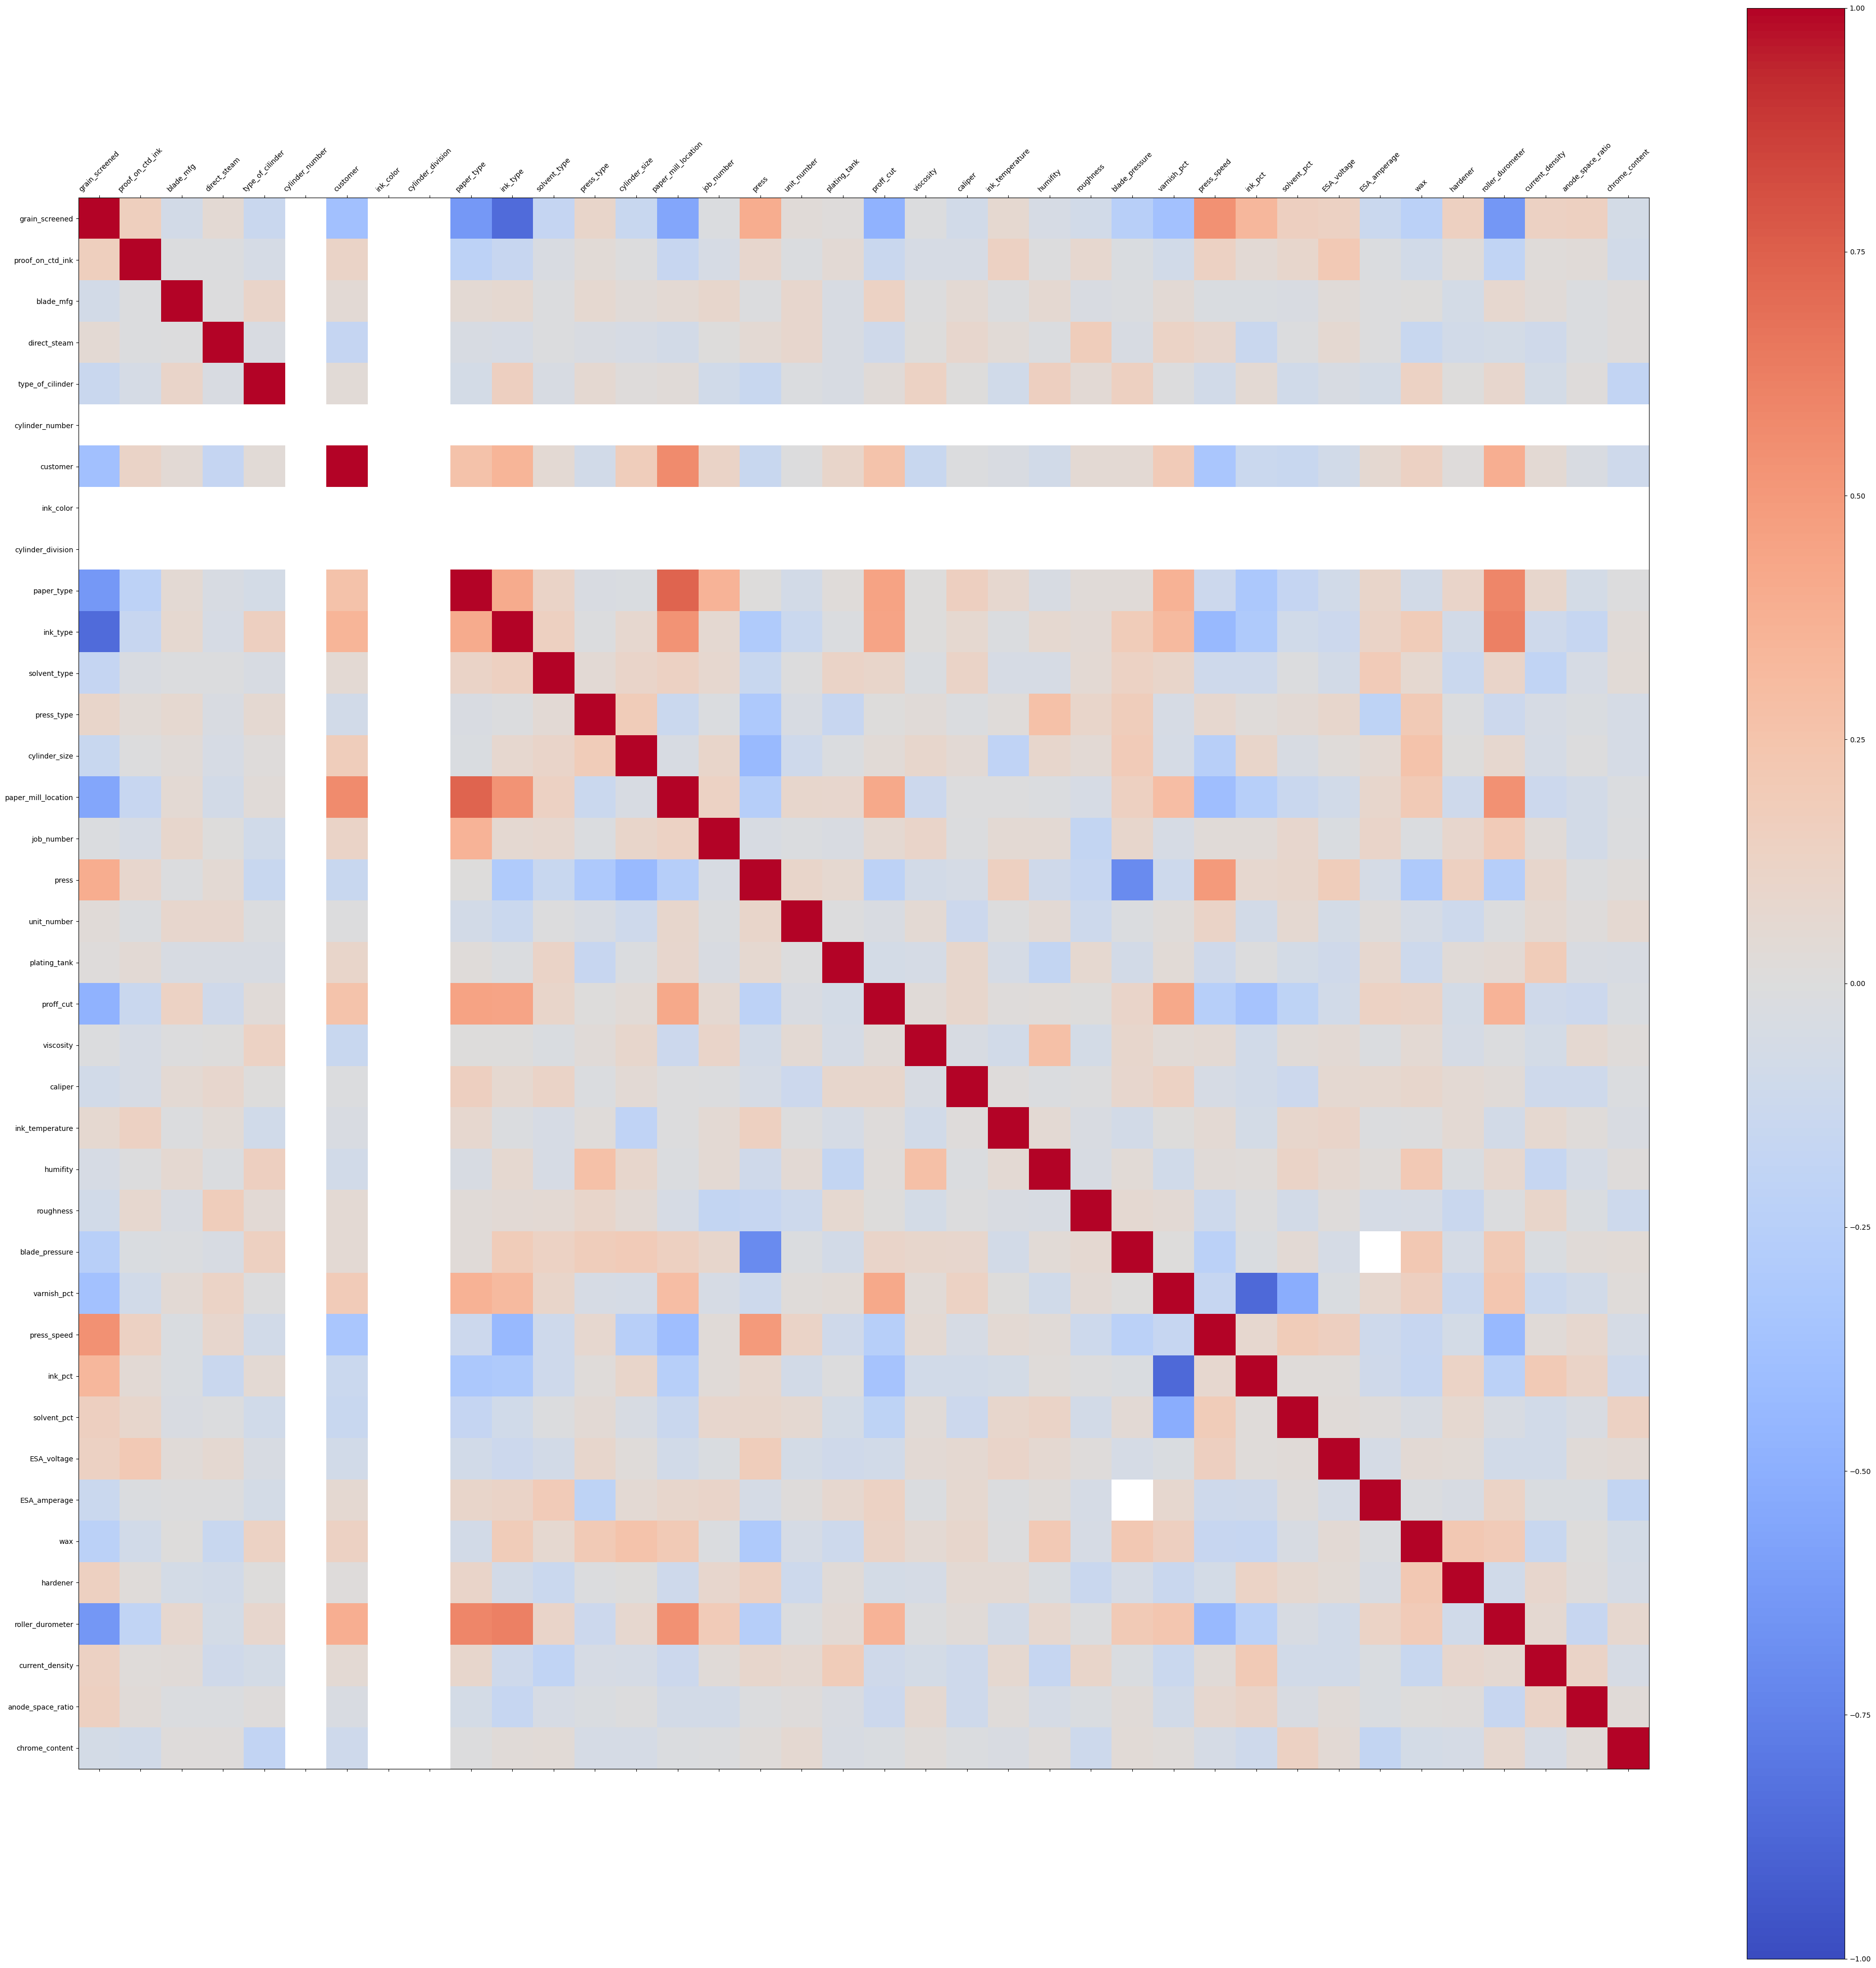

In [20]:
'''
Calculamos y mostramos la matriz de correlación entre variables (del conjunto X_train)
'''
# Calculamos la matriz de correlaciones con la función corr de pandas sobre los datos de train
correlaciones = pd.DataFrame(X_transformada,columns=variablesBinarias+variablesMulticategoricas+variablesNumericas).astype('float64').corr()

# Mostramos la matriz de correlaciones especificando el rango de los valores [-1, 1]
fig = plt.figure(figsize=(50,50))
ax = fig.add_subplot(111)
cax = ax.matshow(correlaciones, vmin=-1, vmax=1, cmap=plt.cm.coolwarm)
fig.colorbar(cax)
ticks = np.arange(0,len(variablesBinarias+variablesMulticategoricas+variablesNumericas),1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)

# Añadimos los nombres de las variables en la figura
names = variablesBinarias+variablesMulticategoricas+variablesNumericas
ax.set_xticklabels(names, rotation='45')
ax.set_yticklabels(names)
plt.show()

Observamos que, en general, las variables no se encuentran muy relacionadas entre sí. Para no modificar excesivamente esto, vamos a usar un imputador no lineal. Vamos a probar 2 diferentes: `IterativeImputer` (con el estimador siendo un `RandomForestRegresor`) y un `KNNImputer`.

In [21]:
'''
Utilizamos tanto IterativeImputer y KNNImputer
'''
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer,KNNImputer
from sklearn.ensemble import RandomForestRegressor

#Creamos los objetos para realizar los imputadores


#Utilizamos como "initial_strategy" la mediana ya que no hemos comprobado la dsitribucion de los valores en las variables. 
#Forma de que afecte lo menos posible el ruido.
imputerIterativo = IterativeImputer(estimator=RandomForestRegressor(random_state=33),initial_strategy="median",random_state=33)
imputerKNN = KNNImputer(weights="distance")
imputadores = [imputerIterativo,imputerKNN]

#Creamos los objetos para realizar las transformaciones
transBinario = ce.OrdinalEncoder(handle_missing='return_nan')
transMulticategorico = ce.TargetEncoder(handle_missing='return_nan',smoothing=0.000001,min_samples_leaf=10)

for imputador in imputadores:
    #Creamos el el proceso entre columnas
    columnaBinaria = Pipeline([('transformacion',transBinario),
                                ('imputador', imputador)])
    columnaMultivariante = Pipeline([('transformacion',transMulticategorico),
                                ('imputador', imputador)])
    columnaNumerica = Pipeline([('imputador', imputador)])

    #Creamos y ejecutamos el transformador de columnas
    preprocesamiento = ColumnTransformer([('binarias',columnaBinaria,variablesBinarias),
                                        ('multicategoricas',columnaMultivariante,variablesMulticategoricas),
                                        ('numericas',columnaNumerica,variablesNumericas)],
                                        verbose=True)

    aux = preprocesamiento.fit_transform(X_train,y_train)
    display(preprocesamiento)
    display(pd.DataFrame(aux,columns=variablesBinarias+variablesMulticategoricas+variablesNumericas))

[ColumnTransformer] ...... (1 of 3) Processing binarias, total=   1.2s
[ColumnTransformer]  (2 of 3) Processing multicategoricas, total=   2.5s
[ColumnTransformer] ..... (3 of 3) Processing numericas, total=  43.3s


ColumnTransformer(transformers=[('binarias',
                                 Pipeline(steps=[('transformacion',
                                                  OrdinalEncoder(handle_missing='return_nan')),
                                                 ('imputador',
                                                  IterativeImputer(estimator=RandomForestRegressor(random_state=33),
                                                                   initial_strategy='median',
                                                                   random_state=33))]),
                                 ['grain_screened', 'proof_on_ctd_ink',
                                  'blade_mfg', 'direct_steam',
                                  'type_of_cilinder']),
                                ('multicategorica...
                                                                   random_state=33))]),
                                 ['job_number', 'press', 'unit_number',
                                  'plating_tank', 'proff_cut', 'viscosity',
                                  'caliper', 'ink_temperature', 'humifity',
                                  'roughness', 'blade_pressure', 'varnish_pct',
                                  'press_speed', 'ink_pct', 'solvent_pct',
                                  'ESA_voltage', 'ESA_amperage', 'wax',
                                  'hardener', 'roller_durometer',
                                  'current_density', 'anode_space_ratio',
                                  'chrome_content'])],
                  verbose=True)

,grain_screened,proof_on_ctd_ink,blade_mfg,direct_steam,type_of_cilinder,cylinder_number,customer,ink_color,cylinder_division,paper_type,ink_type,solvent_type,press_type,cylinder_size,paper_mill_location,job_number,press,unit_number,plating_tank,proff_cut,viscosity,caliper,ink_temperature,humifity,roughness,blade_pressure,varnish_pct,press_speed,ink_pct,solvent_pct,ESA_voltage,ESA_amperage,wax,hardener,roller_durometer,current_density,anode_space_ratio,chrome_content
0,1.0,1.000000,1.0,1.0,1.000000,1.421405,1.500000,1.421405,1.421405,1.43125,1.529412,1.341176,1.368000,1.394904,1.371134,25503.0,821.0,2.0,1910.36,55.000,46.0,0.3,15.0000,80.0,0.7500,20.00,6.600,1900.0,54.900,38.500,0.000,0.00,2.5,0.70,34.00,40.0,105.00,100.0
1,1.0,1.000000,1.0,1.0,1.000000,1.421405,1.421405,1.421405,1.421405,1.43125,1.529412,1.421405,1.465116,1.428571,1.421405,38240.0,802.0,7.0,1911.00,60.000,46.0,333.0,15.6954,80.0,625.0000,50.00,12.400,1391.0,51.500,36.100,2.000,0.00,2.7,1.00,38.50,40.0,114.29,100.0
2,2.0,1.000000,1.0,1.0,1.000000,1.421405,1.190476,1.421405,1.421405,1.33871,1.311765,1.341176,1.368000,1.394904,1.260870,37338.0,824.0,2.0,1911.00,47.500,60.0,0.4,14.5000,74.0,0.8125,20.00,8.600,1600.0,53.800,37.600,0.000,0.00,2.0,1.50,35.00,40.0,110.00,100.0
3,2.0,1.000000,1.0,1.0,2.000000,1.421405,1.190476,1.421405,1.421405,1.33871,1.311765,1.341176,1.530000,1.394904,1.260870,37333.0,815.0,2.0,1910.00,35.000,56.0,0.3,15.3000,80.0,0.7500,20.00,0.000,1900.0,76.900,23.100,0.000,0.00,2.5,1.25,33.00,40.0,106.66,100.0
4,1.0,1.000000,1.0,1.0,2.000000,1.421405,1.421405,1.421405,1.421405,1.43125,1.529412,1.341176,1.530000,1.428571,1.371134,38025.0,815.0,2.0,1910.00,55.000,55.0,0.3,13.0000,86.0,0.7500,28.00,13.700,1700.0,49.000,37.300,0.000,0.00,3.0,0.80,34.00,35.0,100.00,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,1.0,1.000000,1.0,1.0,1.000000,1.421405,1.421405,1.421405,1.421405,1.43125,1.529412,1.341176,1.530000,1.428571,1.371134,37000.0,815.0,2.0,1911.00,65.000,43.0,333.0,16.0000,75.0,1.0000,32.00,22.700,1750.0,45.500,31.800,0.000,0.00,3.0,1.00,38.00,40.0,106.66,100.0
295,2.0,1.000000,1.0,1.0,2.000000,1.421405,1.476190,1.421405,1.421405,1.43125,1.311765,1.341176,1.368000,1.394904,1.371134,36166.0,828.0,2.0,1910.00,45.000,43.0,0.2,16.0000,80.0,0.7500,30.00,3.100,2200.0,51.000,45.900,0.000,0.00,2.5,1.30,35.00,40.0,103.33,100.0
296,1.0,1.000000,1.0,1.0,2.000000,1.421405,1.421405,1.421405,1.421405,1.43125,1.710702,1.341176,1.225806,1.428571,1.371134,36911.0,813.0,6.0,1910.00,50.000,59.0,0.4,15.0000,90.0,0.7500,28.81,0.000,1500.0,58.800,41.200,0.000,0.00,2.5,1.00,40.00,35.0,100.00,100.0
297,2.0,1.000000,1.0,1.0,1.000000,1.421405,1.272727,1.421405,1.421405,1.33871,1.311765,1.341176,1.368000,1.394904,1.260870,37163.0,821.0,2.0,1910.00,55.000,37.0,267.0,16.0000,75.0,625.0000,20.00,5.600,1850.0,55.600,38.900,0.000,0.00,0.8,0.75,33.00,40.0,109.67,100.0


[ColumnTransformer] ...... (1 of 3) Processing binarias, total=   0.1s
[ColumnTransformer]  (2 of 3) Processing multicategoricas, total=   0.1s
[ColumnTransformer] ..... (3 of 3) Processing numericas, total=   0.0s


ColumnTransformer(transformers=[('binarias',
                                 Pipeline(steps=[('transformacion',
                                                  OrdinalEncoder(handle_missing='return_nan')),
                                                 ('imputador',
                                                  KNNImputer(weights='distance'))]),
                                 ['grain_screened', 'proof_on_ctd_ink',
                                  'blade_mfg', 'direct_steam',
                                  'type_of_cilinder']),
                                ('multicategoricas',
                                 Pipeline(steps=[('transformacion',
                                                  TargetEncoder(handle_missing='return_nan'...
                                                  KNNImputer(weights='distance'))]),
                                 ['job_number', 'press', 'unit_number',
                                  'plating_tank', 'proff_cut', 'viscosity',
                                  'caliper', 'ink_temperature', 'humifity',
                                  'roughness', 'blade_pressure', 'varnish_pct',
                                  'press_speed', 'ink_pct', 'solvent_pct',
                                  'ESA_voltage', 'ESA_amperage', 'wax',
                                  'hardener', 'roller_durometer',
                                  'current_density', 'anode_space_ratio',
                                  'chrome_content'])],
                  verbose=True)

,grain_screened,proof_on_ctd_ink,blade_mfg,direct_steam,type_of_cilinder,cylinder_number,customer,ink_color,cylinder_division,paper_type,ink_type,solvent_type,press_type,cylinder_size,paper_mill_location,job_number,press,unit_number,plating_tank,proff_cut,viscosity,caliper,ink_temperature,humifity,roughness,blade_pressure,varnish_pct,press_speed,ink_pct,solvent_pct,ESA_voltage,ESA_amperage,wax,hardener,roller_durometer,current_density,anode_space_ratio,chrome_content
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.421405,1.500000,1.421405,1.421405,1.43125,1.529412,1.341176,1.368000,1.394904,1.371134,25503.0,821.0,2.0,1910.482585,55.000000,46.0,0.3,15.000000,80.0,0.7500,20.000000,6.60000,1900.0,54.900000,38.500000,0.000000,0.0,2.5,0.70,34.000000,40.0,105.00,100.0
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.421405,1.421405,1.421405,1.421405,1.43125,1.529412,1.421405,1.465116,1.428571,1.421405,38240.0,802.0,7.0,1911.000000,60.000000,46.0,333.0,16.750048,80.0,625.0000,50.000000,12.40000,1391.0,51.500000,36.100000,2.000000,0.0,2.7,1.00,38.500000,40.0,114.29,100.0
2,2.000000,1.000000,1.000000,1.000000,1.000000,1.421405,1.190476,1.421405,1.421405,1.33871,1.311765,1.341176,1.368000,1.394904,1.260870,37338.0,824.0,2.0,1911.000000,47.500000,60.0,0.4,14.500000,74.0,0.8125,20.000000,8.60000,1600.0,53.800000,37.600000,0.000000,0.0,2.0,1.50,35.000000,40.0,110.00,100.0
3,2.000000,1.000000,1.000000,1.000000,2.000000,1.421405,1.190476,1.421405,1.421405,1.33871,1.311765,1.341176,1.530000,1.394904,1.260870,37333.0,815.0,2.0,1910.000000,35.000000,56.0,0.3,15.300000,80.0,0.7500,20.000000,0.00000,1900.0,76.900000,23.100000,0.000000,0.0,2.5,1.25,33.000000,40.0,106.66,100.0
4,1.000000,1.000000,1.000000,1.000000,2.000000,1.421405,1.421405,1.421405,1.421405,1.43125,1.529412,1.341176,1.530000,1.428571,1.371134,38025.0,815.0,2.0,1910.000000,55.000000,55.0,0.3,13.000000,86.0,0.7500,28.000000,13.70000,1700.0,49.000000,37.300000,0.000000,0.0,3.0,0.80,34.000000,35.0,100.00,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,1.000000,1.000000,1.000000,1.000000,1.000000,1.421405,1.421405,1.421405,1.421405,1.43125,1.529412,1.341176,1.530000,1.428571,1.371134,37000.0,815.0,2.0,1911.000000,65.000000,43.0,333.0,16.000000,75.0,1.0000,32.000000,22.70000,1750.0,45.500000,31.800000,0.000000,0.0,3.0,1.00,38.000000,40.0,106.66,100.0
295,2.000000,1.000000,1.000000,1.000000,2.000000,1.421405,1.476190,1.421405,1.421405,1.43125,1.311765,1.341176,1.368000,1.394904,1.371134,36166.0,828.0,2.0,1910.000000,45.000000,43.0,0.2,16.000000,80.0,0.7500,30.000000,3.10000,2200.0,51.000000,45.900000,0.000000,0.0,2.5,1.30,35.000000,40.0,103.33,100.0
296,1.000000,1.000000,1.000000,1.000000,2.000000,1.421405,1.421405,1.421405,1.421405,1.43125,1.710702,1.341176,1.225806,1.428571,1.371134,36911.0,813.0,6.0,1910.000000,50.000000,59.0,0.4,15.000000,90.0,0.7500,53.442427,0.00000,1500.0,58.800000,41.200000,0.000000,0.0,2.5,1.00,40.000000,35.0,100.00,100.0
297,2.000000,1.000000,1.000000,1.000000,1.000000,1.421405,1.272727,1.421405,1.421405,1.33871,1.311765,1.341176,1.368000,1.394904,1.260870,37163.0,821.0,2.0,1910.000000,55.000000,37.0,267.0,16.000000,75.0,625.0000,20.000000,5.60000,1850.0,55.600000,38.900000,0.000000,0.0,0.8,0.75,33.000000,40.0,109.67,100.0


Vamos a probar ambos transformadores con un modelo único. Usaremos aquel que nos arroje mejores resultados de media.

In [22]:
'''
Creamos y probamos ambos transformadores con un DecisionTreeClassifier
'''
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

#Creamos el clasificador
arbol = DecisionTreeClassifier(criterion='entropy',min_samples_leaf=0.01,min_samples_split=0.06,random_state=33)

for imputador in imputadores:
    #Creamos el el proceso entre columnas
    columnaBinaria = Pipeline([('transformacion',transBinario),
                                ('imputador', imputador)])
    columnaMultivariante = Pipeline([('transformacion',transMulticategorico),
                                ('imputador', imputador)])
    columnaNumerica = Pipeline([('imputador', imputador)])

    #Creamos y ejecutamos el transformador de columnas
    preprocesamiento = ColumnTransformer([('binarias',columnaBinaria,variablesBinarias),
                                        ('multicategoricas',columnaMultivariante,variablesMulticategoricas),
                                        ('numericas',columnaNumerica,variablesNumericas)])
    
    # Creamos la Pipeline: pre-procesamiento y arbol
    clasificador =  Pipeline([('preprocesamiento',preprocesamiento),
                            ('modelo',arbol)],
                            verbose=True)

    clasificador = clasificador.fit(X_train,y_train)
    errorVal = accuracy_score(y_val,clasificador.predict(X_val))
    errorTest = accuracy_score(y_test,clasificador.predict(X_test))
    print("\Precisión en VALIDACION: {}%".format(round(errorVal*100,5)))
    #print("Precisión en el TEST: {}%".format(round(errorTest*100,5))) Diría que esto es ilegal, preguntar a Julen
    display(clasificador)

[Pipeline] .. (step 1 of 2) Processing preprocesamiento, total=  45.9s
[Pipeline] ............ (step 2 of 2) Processing modelo, total=   0.0s
\Precisión en VALIDACION: 71.05263%


Pipeline(steps=[('preprocesamiento',
                 ColumnTransformer(transformers=[('binarias',
                                                  Pipeline(steps=[('transformacion',
                                                                   OrdinalEncoder(handle_missing='return_nan')),
                                                                  ('imputador',
                                                                   IterativeImputer(estimator=RandomForestRegressor(random_state=33),
                                                                                    initial_strategy='median',
                                                                                    random_state=33))]),
                                                  ['grain_screened',
                                                   'proof_on_ctd_ink',
                                                   'blade_mfg', 'direct_steam',
                                                   't...
                                                   'ink_temperature',
                                                   'humifity', 'roughness',
                                                   'blade_pressure',
                                                   'varnish_pct', 'press_speed',
                                                   'ink_pct', 'solvent_pct',
                                                   'ESA_voltage',
                                                   'ESA_amperage', 'wax',
                                                   'hardener',
                                                   'roller_durometer',
                                                   'current_density',
                                                   'anode_space_ratio',
                                                   'chrome_content'])])),
                ('modelo',
                 DecisionTreeClassifier(criterion='entropy',
                                        min_samples_leaf=0.01,
                                        min_samples_split=0.06,
                                        random_state=33))],
         verbose=True)

[Pipeline] .. (step 1 of 2) Processing preprocesamiento, total=   0.2s
[Pipeline] ............ (step 2 of 2) Processing modelo, total=   0.0s
\Precisión en VALIDACION: 64.47368%


Pipeline(steps=[('preprocesamiento',
                 ColumnTransformer(transformers=[('binarias',
                                                  Pipeline(steps=[('transformacion',
                                                                   OrdinalEncoder(handle_missing='return_nan')),
                                                                  ('imputador',
                                                                   KNNImputer(weights='distance'))]),
                                                  ['grain_screened',
                                                   'proof_on_ctd_ink',
                                                   'blade_mfg', 'direct_steam',
                                                   'type_of_cilinder']),
                                                 ('multicategoricas',
                                                  Pipeline(steps=[('transformacion',
                                                                   Targe...
                                                   'ink_temperature',
                                                   'humifity', 'roughness',
                                                   'blade_pressure',
                                                   'varnish_pct', 'press_speed',
                                                   'ink_pct', 'solvent_pct',
                                                   'ESA_voltage',
                                                   'ESA_amperage', 'wax',
                                                   'hardener',
                                                   'roller_durometer',
                                                   'current_density',
                                                   'anode_space_ratio',
                                                   'chrome_content'])])),
                ('modelo',
                 DecisionTreeClassifier(criterion='entropy',
                                        min_samples_leaf=0.01,
                                        min_samples_split=0.06,
                                        random_state=33))],
         verbose=True)

Vemos una clara mejora en los resultados de validación en el proceso de imputar los valores mediante el uso de `IterativeImputer`. De ahora en adelante vamos a utilizar este imputador como parte principal del programa.

Vamos a volver a calcular la matriz de correlacion para observar si se ha producido un gran cambio o no.

In [23]:
#Creamos el nuevo X_transformada
columnaBinaria = Pipeline([('transformacion',transBinario),
                            ('imputador', imputerIterativo)])
columnaMultivariante = Pipeline([('transformacion',transMulticategorico),
                            ('imputador', imputerIterativo)])
columnaNumerica = Pipeline([('imputador', imputerIterativo)])

#Creamos y ejecutamos el transformador de columnas
preprocesamiento = ColumnTransformer([('binarias',columnaBinaria,variablesBinarias),
                                    ('multicategoricas',columnaMultivariante,variablesMulticategoricas),
                                    ('numericas',columnaNumerica,variablesNumericas)],
                                     verbose=True)

X_transformada = preprocesamiento.fit_transform(X_train,y_train)

[ColumnTransformer] ...... (1 of 3) Processing binarias, total=   1.3s
[ColumnTransformer]  (2 of 3) Processing multicategoricas, total=   2.5s
[ColumnTransformer] ..... (3 of 3) Processing numericas, total=  42.3s


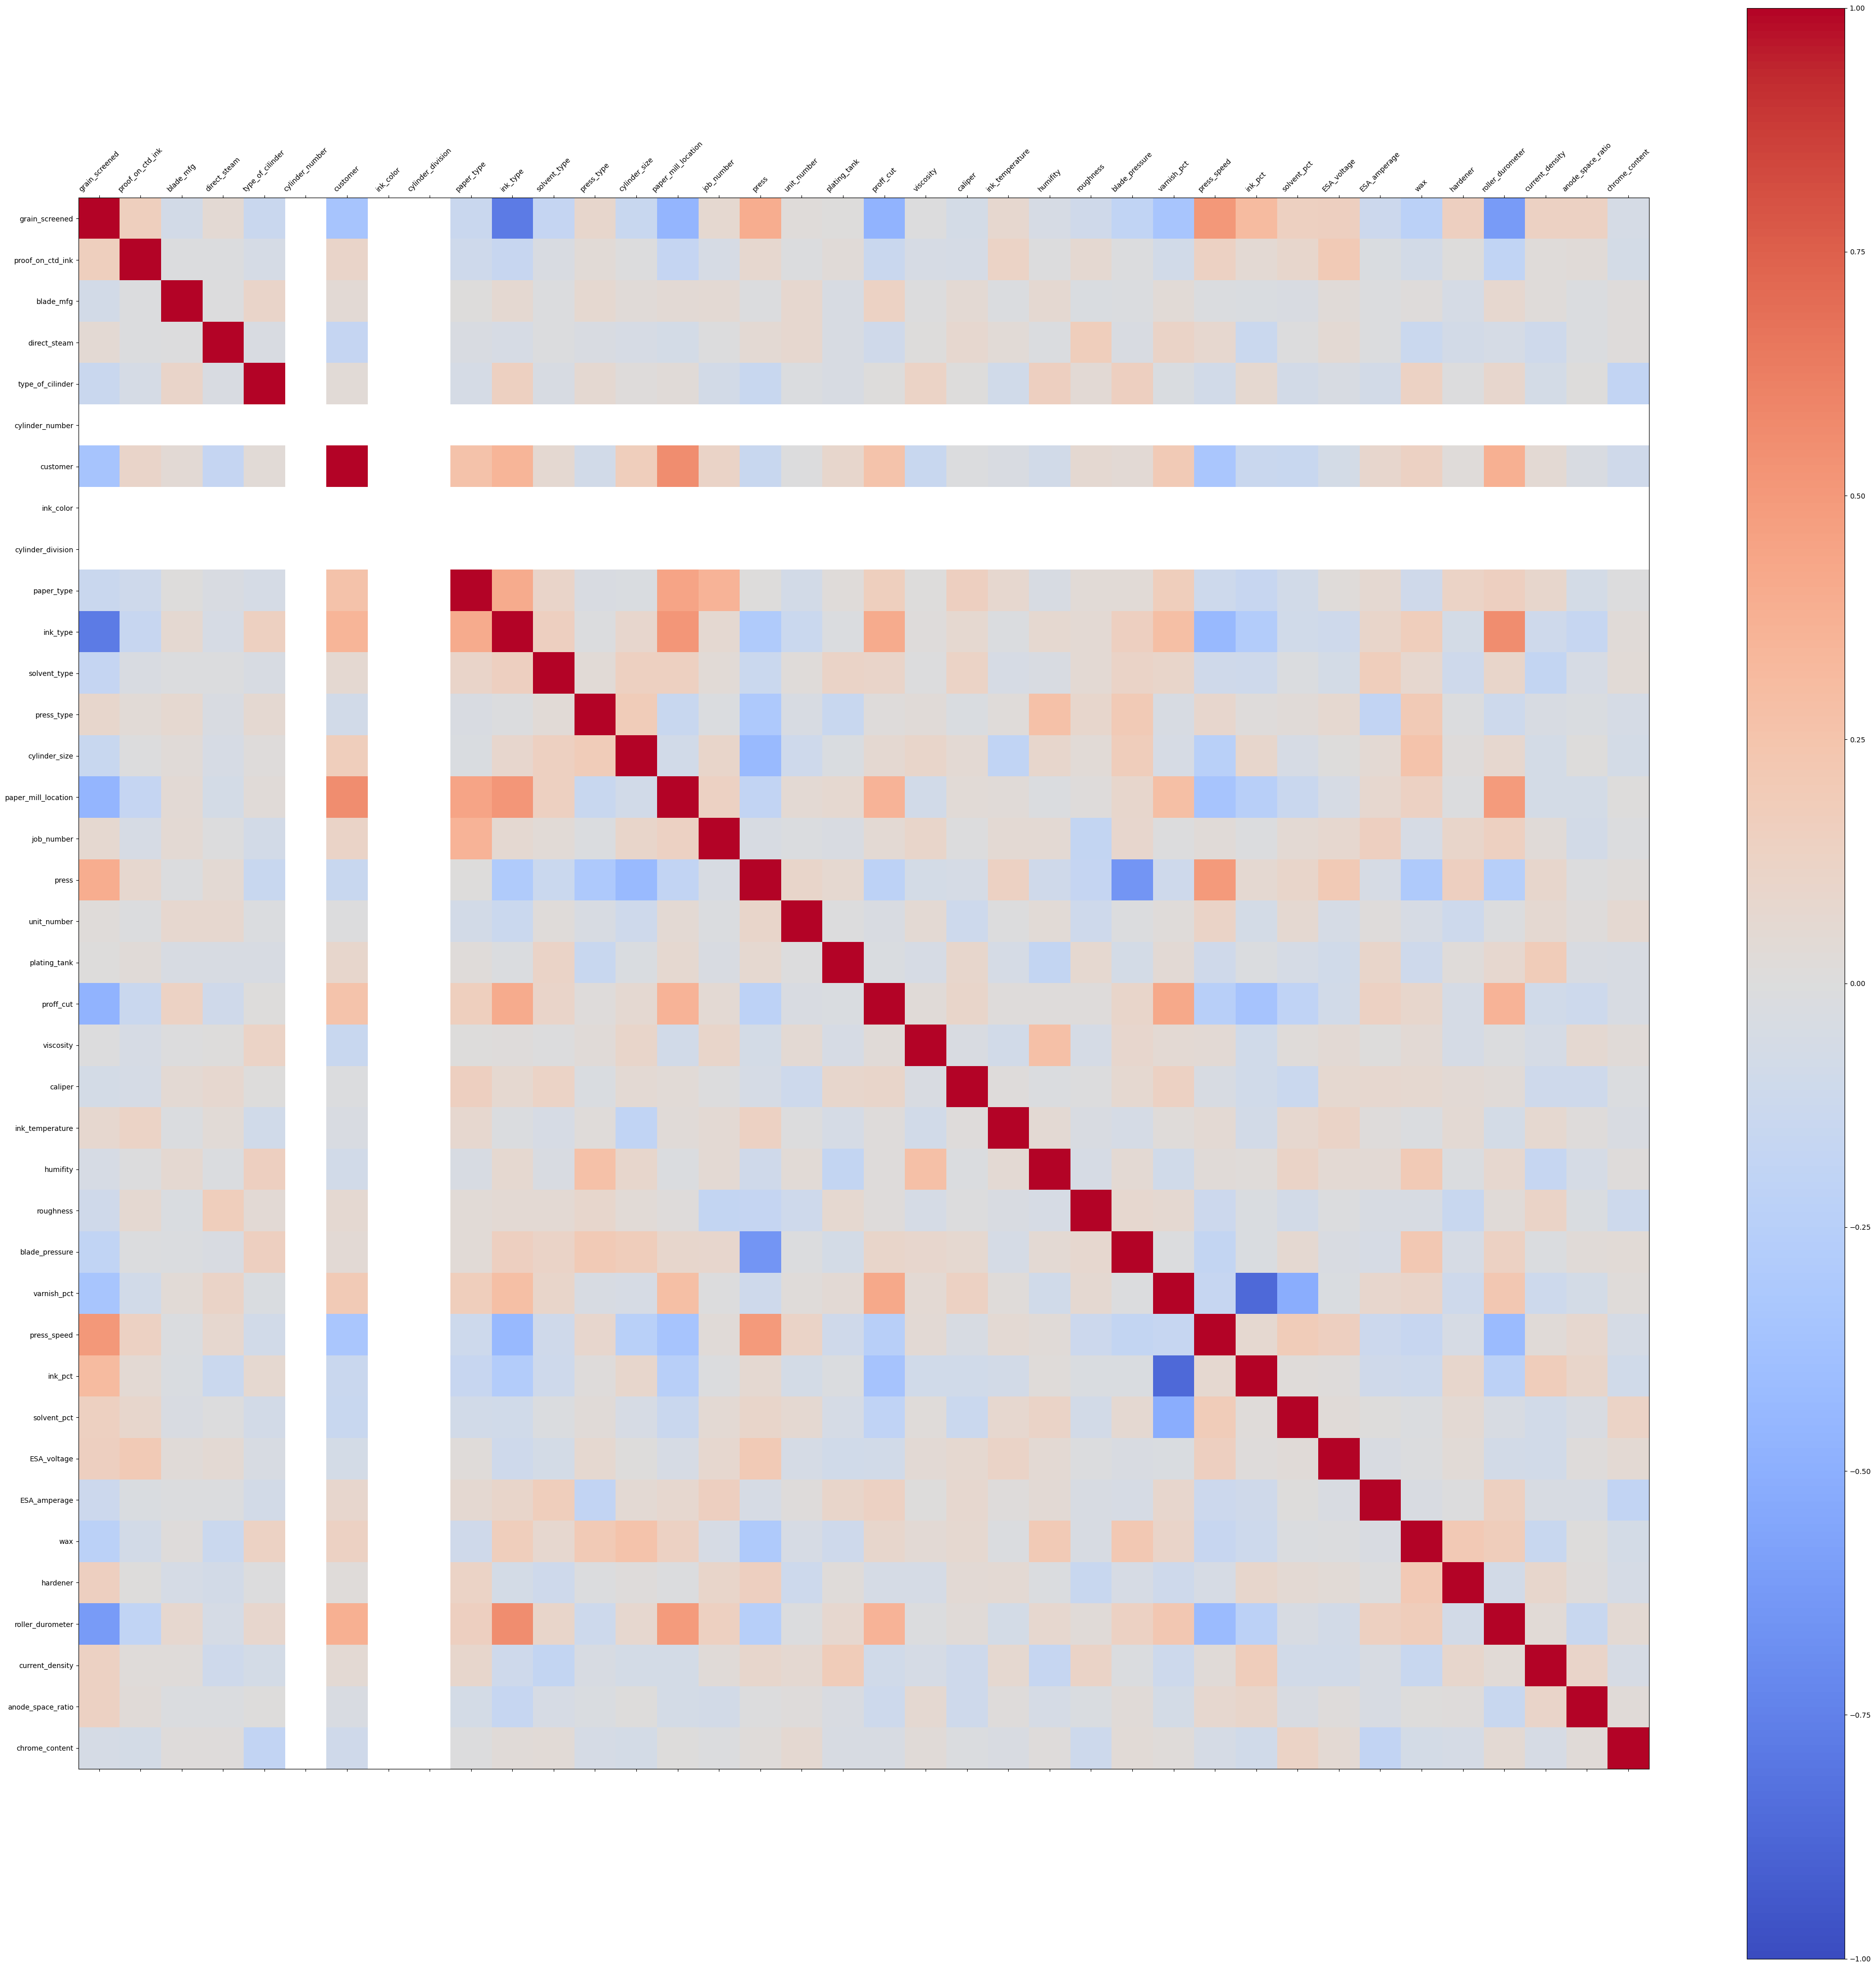

In [24]:
'''
Calculamos y mostramos la matriz de correlación entre variables (del conjunto X_train)
'''
# Calculamos la matriz de correlaciones con la función corr de pandas sobre los datos de train
correlaciones = pd.DataFrame(X_transformada,columns=variablesBinarias+variablesMulticategoricas+variablesNumericas).astype('float64').corr()

# Mostramos la matriz de correlaciones especificando el rango de los valores [-1, 1]
fig = plt.figure(figsize=(50,50))
ax = fig.add_subplot(111)
cax = ax.matshow(correlaciones, vmin=-1, vmax=1, cmap=plt.cm.coolwarm)
fig.colorbar(cax)
ticks = np.arange(0,len(variablesBinarias+variablesMulticategoricas+variablesNumericas),1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)

# Añadimos los nombres de las variables en la figura
names = variablesBinarias+variablesMulticategoricas+variablesNumericas
ax.set_xticklabels(names, rotation='45')
ax.set_yticklabels(names)
plt.show()

Al comparar con la grafica de correlaciones anterior observamos que hemos "neutralizado" las correlaciones. Algunas que eran altas las hemos bajado y otras que eran bajas la hemos subido, dejando ambas mas cercanas al 0. Esto ayudará en un futuro.

### 5.3: Oversampling / Undersampling <a class="anchor" id="5.3"></a>

El siguiente paso a realizar es averiguar si se realiza un balanceo o no de los datos, y si es así, por metodo de `oversampling` o `undersampling`.

In [25]:
'''
Compruebo la cantidad de valores únicos en el conjunto de train
'''
_,salida = np.unique(y,return_counts=True)
print("Total BAND (total): {}\nTotal NOBAND (total): {}\n".format(salida[0],salida[1]))

_,salida = np.unique(y_train,return_counts=True)
print("Total BAND (train): {}\nTotal NOBAND (test): {}".format(salida[0],salida[1]))

Total BAND (total): 227
Total NOBAND (total): 312

Total BAND (train): 173
Total NOBAND (test): 126


Observamos que el conjunto *NOBAND* cuenta con un mayor número de ejemplos. Al haber empleado una estratificación de los datos al principio, hemos distribuido esta diferencia, pero sigue siendo notable al imprimir el conjunto total de los datos. Por tanto, decidimos que es recomendable eliminar o crear ejemplos para paliar este desnivel.

Para esto, vamos a probar un conjunto de técnicas distintas y observar qué impacto tienen sobre los resultados obtenidos por un modelo de predicción. 

In [26]:
'''
Vamos a poner a prueba una serie de tecnicas y decatnarnos por la mejor
'''
from imblearn import under_sampling as us, over_sampling as os, combine as co

#Creacion de la lista de tecincas
listaTecnicas = [us.RandomUnderSampler(random_state=33),
                us.TomekLinks(),
                us.AllKNN(),
                us.NeighbourhoodCleaningRule(),
                os.RandomOverSampler(random_state=33),
                os.SMOTE(random_state=33),
                os.KMeansSMOTE(random_state=33),
                os.SVMSMOTE(random_state=33),
                co.SMOTETomek(random_state=33),
                co.SMOTEENN(random_state=33)]

nombres = ["RandomUnderSampler", "TomekLinks", "AllKNN", "NeighbourhoodCleaningRule", "RandomOverSampler", "SMOTE", "KMeansSMOTE", "SVMSMOTE", "SMOTETomek", "SMOTEEN"]

resultados = pd.DataFrame(columns=nombres,index=["Parametros ORIGINALES", "Parametros SAMPLEADOS", "Acierto VALIDACION", "Acierto TEST"])

#Creamos un bucle donde visualizamos los resultados de cada iteracion
for tecnica,nombre in zip(listaTecnicas,nombres):

    #Utilizamos los datos transformados anteriormente
    X_sampled, y_sampled = tecnica.fit_resample(X_transformada,y_train)
    
    #Utilizamos el mismo clasificador de antes con el mejor preprocesamiento para poder intentar predecir los valores de validacion y test
    clasificador =  Pipeline([('preprocesamiento',preprocesamiento)], verbose=True)
    
    #Usamos el mismo clasificador que anteriormente y lo añadimos a la pipeline una vez ya entrenad0
    arbol = DecisionTreeClassifier(criterion='entropy',min_samples_leaf=0.01,min_samples_split=0.06,random_state=33)
    arbol = arbol.fit(X_sampled,y_sampled)
    
    params = clasificador.get_params()
    params['steps'].append(('arbol', arbol))
    clasificador.set_params(**params)

    #Mostramos los resultados
    resultados[nombre]["Parametros ORIGINALES"] = collections.Counter(y_train.values.flatten())
    resultados[nombre]["Parametros SAMPLEADOS"] = collections.Counter(y_sampled.values.flatten())
    resultados[nombre]["Acierto VALIDACION"] = round(accuracy_score(y_val,clasificador.predict(X_val))*100,5)
    #resultados[nombre]["Acierto TEST"] = round(accuracy_score(y_test,clasificador.predict(X_test))*100,5) #Diría que esto es ilegal, preguntar a Julen
    
resultados

,RandomUnderSampler,TomekLinks,AllKNN,NeighbourhoodCleaningRule,RandomOverSampler,SMOTE,KMeansSMOTE,SVMSMOTE,SMOTETomek,SMOTEEN
Parametros ORIGINALES,"{1: 173, 2: 126}","{1: 173, 2: 126}","{1: 173, 2: 126}","{1: 173, 2: 126}","{1: 173, 2: 126}","{1: 173, 2: 126}","{1: 173, 2: 126}","{1: 173, 2: 126}","{1: 173, 2: 126}","{1: 173, 2: 126}"
Parametros SAMPLEADOS,"{1: 126, 2: 126}","{1: 144, 2: 126}","{1: 116, 2: 126}","{1: 117, 2: 126}","{1: 173, 2: 173}","{1: 173, 2: 173}","{1: 173, 2: 173}","{1: 173, 2: 173}","{1: 153, 2: 153}","{1: 48, 2: 59}"
Acierto VALIDACION,71.05263,61.84211,67.10526,52.63158,72.36842,59.21053,69.73684,61.84211,63.15789,55.26316
Acierto TEST,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Vemos claramente que donde se ha obtenido un mayor resultado respecto a los demás metodos es en el `RandomOverSampler` obteniendo este un total de **72,36%** de acierto en validación, mejorando el obtenido anteriormente sin el sampleo de **71,05%**. 

¿Y por qué obtiene mejores resultados un método aleatorio? En primer lugar, añadir ejemplos respecto a quitarlos debería funcionar mejor, como es nuestro caso, para problemas con no demasiados ejemplos, pues eliminar parte de estos supone perder un porcentaje considerable de la información. Dentro de los métodos de *Oversampling*, por otro lado, el aleatorio puede devolvernos los mejores resultados por no crear valores "imposibles". Recordemos que antes hemos transformado las variables categóricas a numéricas, con lo que en estas variables no pueden existir, por ejemplo, valores decimales. Otros métodos de *OverSampling* crearán este tipo de valores imposibles confundiendo al clasificador, mientras que el método aleatorio replicará los valores que ya existen, conservando la lógica de nuestro problema.

In [27]:
'''
Declaramos la variable sampler con el sampleador a utilizar para futuras interacciones
'''
sampler = os.RandomOverSampler(random_state=33)

### 5.4: Eliminación de ruido <a class="anchor" id="5.4"></a>

Vamos a eliminar el ruido de nuestro conjunto de datos. Buscamos eliminar aquellos ejemplos que puedan repercutir negativamente en la predicción de nuestro clasificador por ser instancias en las que no está claro que sean de la clase que les ha sido asignada.

Vamos a probar los siguientes métodos: 
1. [*TomekLinks*](https://imbalanced-learn.org/dev/references/generated/imblearn.under_sampling.TomekLinks.html)
2. [*EditedNearestNeighbours*](https://imbalanced-learn.org/dev/references/generated/imblearn.under_sampling.EditedNearestNeighbours.html)
3. [*AllKNN*](https://imbalanced-learn.org/dev/references/generated/imblearn.under_sampling.AllKNN.html)
4. [*ClusterCentroids*](https://imbalanced-learn.org/dev/references/generated/imblearn.under_sampling.ClusterCentroids.html)

En el caso de los tres primeros, implementamos los métodos que conocemos de prácticas anteriores para evaluar su rendimiento en nuestro conjunto de datos. Además, añadimos el ClusterCentroids, método basado, como su nombre indica, en la creación de clústeres y reemplazando todos los ejemplos de dicho cluster por el centro obtenido por el algoritmo de Kmeans. Nos interesa probar este método para cerciorarnos de cómo de separados están nuestros datos y de qué efecto tiene sobre estos un Kmeans.

In [28]:
'''
Celda para guardar todos los cambios que hemos hecho hasta ahora
'''
X_train_sin_transformar = X_train
y_train_sin_transformar = y_train
X_val_sin_transformar = X_val

X_train = X_transformada #En X_transformada ya están guardados los elementos transformados de categórico a numérico e imputados
X_train,y_train = sampler.fit_resample(X_train,y_train) #Le aplico oversampling
X_val = preprocesamiento.fit_transform(X_val,y_val) #Aplico a X_val la transformación de categórico a numérico y la imputación

[ColumnTransformer] ...... (1 of 3) Processing binarias, total=   0.9s
[ColumnTransformer]  (2 of 3) Processing multicategoricas, total=   2.1s
[ColumnTransformer] ..... (3 of 3) Processing numericas, total=  16.3s


In [29]:
'''
Probamos distintos métodos de eliminación de ruido
'''

from imblearn.pipeline import Pipeline as Pipeline_in

# Se crean listas con los siguientes contenidos
    # Los nombres de los métodos
    # Los constructores de las técnicas de muestreo con los híper-parámetros usados en la primera parte de la práctica
listaMetodos = ['TomekLinks','EditedNearestNeighbours','AllKNN','ClusterCentroids']
listaTecnicas = [us.TomekLinks(sampling_strategy='all'),
                 us.EditedNearestNeighbours(sampling_strategy='all',kind_sel='mode'),
                 us.AllKNN(sampling_strategy='all',kind_sel='mode'),
                 us.ClusterCentroids(sampling_strategy='all',random_state=33)]


nombres = listaMetodos
resultados = pd.DataFrame(columns=nombres,index=["Acierto Train", "Acierto Validación"])

for nombre, metodo in zip(listaMetodos, listaTecnicas):
    # Generamos la pipeline con los componentes adecuados
    pipe = Pipeline_in([(nombre,metodo),
                  ('DT',DecisionTreeClassifier(criterion='entropy',min_samples_leaf=0.01,min_samples_split=0.06,random_state=33))])
    
    pipe.fit(X_train,y_train)


    # Calculo los resultados sobre el conjunto de train
    y_pred = pipe.predict(X_train)
    resultado = np.round(accuracy_score(y_train,y_pred)*100,4)
    resultados[nombre]["Acierto Train"] = round(accuracy_score(y_train,y_pred)*100,5)
    #Idem para validación
    y_pred = pipe.predict(X_val)
    resultado = np.round(accuracy_score(y_val,y_pred)*100,4)
    # Se imprime el resultado obtenido en validación: mostrad el nombre de la técnica y su rendimiento
    resultados[nombre]["Acierto Validación"] = round(accuracy_score(y_val,y_pred)*100,5)
    
resultados

,TomekLinks,EditedNearestNeighbours,AllKNN,ClusterCentroids
Acierto Train,84.9711,78.61272,83.23699,86.99422
Acierto Validación,61.84211,43.42105,50.0,53.94737


Llaman la atención los resultados obtenidos. Vemos un descenso más o menos claro sobre la precisión que obtenemos en el conjunto de validación con respecto al que estábamos obteniendo hasta ahora. ¿Es posible que la eliminación de ruido esté produciendo estos errores? Vamos a comprobarlo prediciendo directamente sobre los conjuntos preprocesados sin usar ningún tipo de eliminación.

In [30]:
'''
Predicción 'a pelo' sobre el conjunto de validación
'''
arbol = DecisionTreeClassifier(criterion='entropy',min_samples_leaf=0.01,min_samples_split=0.06,random_state=33)
arbol.fit(X_train,y_train)
y_pred = arbol.predict(X_val)
print(f'Precisión en validación: {np.round(accuracy_score(y_val,y_pred)*100,5)}')

Precisión en validación: 72.36842


Observamos que, efectivamente, tratar de eliminar el ruido de nuestro conjunto de datos ha tenido un resultado nocivo sobre la predicción. ¿Por qué?

La respuesta corta vuelve a estar en el mencionado tamaño de nuestro conjunto de datos. Siendo este moderadamente pequeño, eliminar aún más instancias por considerarlas "ruido" puede eliminar también parte fundamental de la información, haciéndonos perder precisión en el proceso. Por otro lado, técnicas como `TomekLinks` (que ha obtenido los mejores resultados) trabajan dando por hecho que el ruido de los datos está en la separación entre clases, lo que parece no ser el caso en nuestro problema, vistos los resultados.

En definitiva, optaremos de entrada por no eliminar ruido tras haber comprobado que esto resulta nocivo para la predección, aunque volveremos a ver cual es su efecto al final.

### 5.5: Eliminación de outliers <a class="anchor" id="5.5"></a>
Continuamos con el tratamiento de datos extraños con la eliminación de los outliers, aquellos valores que están muy fuera del rango propio de su variable y que por tanto pueden tratarse de datos mal recogidos o información engañosa por ser demasiado específica.

Para esto, vamos a implementar los dos métodos que conocemos; la eliminación basada en la media y la desviación y la del rango interquartil.

In [31]:
# Importamos la clase TransformerMixin
from sklearn.base import TransformerMixin

# Creamos la clase de detección y tratamiento de Outliers
class OutlierDetecion_treatment_IQR(TransformerMixin):

    # Constructor de la clase
    def __init__(self, k=1.5, columns=None):
        self.k = k
        self.columns = columns
    
    # Método fit
    def fit(self, X, y=None):
        # Transformamos X a DataFrame por si llega un array de Numpy (para compatibilidad en la Pipeline)
        X = pd.DataFrame(X)
        if self.columns == None:
            # Si no se determinan variables en el constructor si tratan todas
            self.columns = X.columns
        self.stats = X.describe()
        # Devolvemos el propio objeto modificado
        return self

    # Método transform
    def transform(self, X):
        # Transformamos X a DataFrame por si llega un array de Numpy (para compatibilidad en la Pipeline)
        X = pd.DataFrame(X)
        # Creamos una copia del DataFrame X para no perder los datos originales
        Xaux = X.copy()
        # Se calula el IQR de cada variable
        IQRs = self.stats.loc['75%'] - self.stats.loc['25%']
        # Se calculan los límites inferiores y superiores   
        limiteInf = self.stats.loc['25%'] - self.k*IQRs
        limiteSup = self.stats.loc['75%'] + self.k*IQRs
        # Se comprueba qué elementos están por encima y por debajo de dichos límites (máscaras de booleanos)  
        menores = X < limiteInf
        mayores = X > limiteSup

        # Se recorren las variables para detectar outliers y tratarlos (sustituir por la mediana de la variable)
        for c in self.columns:
            # obtenemos la lista de booleanos correspondientes a si los valores de los ejemplos son outliers o no para la variable c
            indices = np.logical_or(mayores[c],menores[c])
            # Si hay outliers
            if len(indices > 0):
                Xaux.loc[indices,c] = self.stats.loc['50%',c]#np.median(X.loc[:,c])
        # Se devuelve el DataFrame modificado
        return Xaux
    
    # Método para asignar los valores de los híper-parámetros y que, de este modo, 
        # podamos aplicar GridSearchCV sobre un objeto de esta clase
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    
    # Método para obtener los valores de los híper-parámetros que queramos del modelo (lo usa GridSearchCV al mostrar la mejor configuración)
    def get_params(self, deep=True):
        # Devolvemos los valores de los híper-parámetros del método de preparación de datos
        return {"k": self.k}

In [32]:
# Creamos la clase de detección y tratamiento de Outliers
# Importamos la clase TransformerMixin
from sklearn.base import TransformerMixin

# Creamos la clase de detección y tratamiento de Outliers
class OutlierDetecion_treatment_MeanStd(TransformerMixin):

    # Constructor de la clase
    def __init__(self, k=2, columns=None):
        self.k = k
        self.columns = columns
        self.media = []
        self.desviacion = []
        self.mediana = []
    
    # Método fit
    def fit(self, X, y=None):
        # Transformamos X a DataFrame por si llega un array de Numpy (para compatibilidad en la Pipeline)
        X = pd.DataFrame(X)
        if self.columns == None:
            # Si no se determinan variables en el constructor si tratan todas
            self.columns = X.columns
        self.stats = X.describe()
        #Guardamos la media, desviación y mediana
        for variable in self.columns:
            self.media.append(np.mean(X.loc[:,variable]))
            self.desviacion.append(np.std(X.loc[:,variable]))
            self.mediana.append(np.median(X.loc[:,variable]))
        # Devolvemos el propio objeto modificado
        return self

    # Método transform
    def transform(self, X):
        # Transformamos X a DataFrame por si llega un array de Numpy (para compatibilidad en la Pipeline)
        X = pd.DataFrame(X)
        # Creamos una copia del DataFrame X para no perder los datos originales
        Xaux = X.copy()
        # Se recorren las variables para detectar outliers y tratarlos (sustituir por la mediana de la variable)
        for i,c in enumerate(self.columns):
            #Calculo las máscaras booleanas de los outliers
            menores = X.loc[:,c] < (self.media[i] - (self.k * self.desviacion[i]))
            mayores = X.loc[:,c] > (self.media[i] + (self.k * self.desviacion[i]))
            #Sustituyo los outliers por la mediana de la variable a la que pertenecen
            if(len(menores) > 0):
                Xaux.loc[menores,c] = self.mediana[i]
            if(len(mayores) > 0):
                Xaux.loc[mayores,c] = self.mediana[i]
        # Se devuelve el DataFrame modificado
        return Xaux
    
    # Método para asignar los valores de los híper-parámetros y que, de este modo, 
        # podamos aplicar GridSearchCV sobre un objeto de esta clase
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    
    # Método para obtener los valores de los híper-parámetros que queramos del modelo (lo usa GridSearchCV al mostrar la mejor configuración)
    def get_params(self, deep=True):
        # Devolvemos los valores de los híper-parámetros del método de preparación de datos
        return {"k": self.k}

Una vez implementados los métodos, probemos cómo funcionan sobre nuestros datos y qué efectos tienen en el rendimiento de los mismos.

Valor máximo de precisión en validación de 69.73684


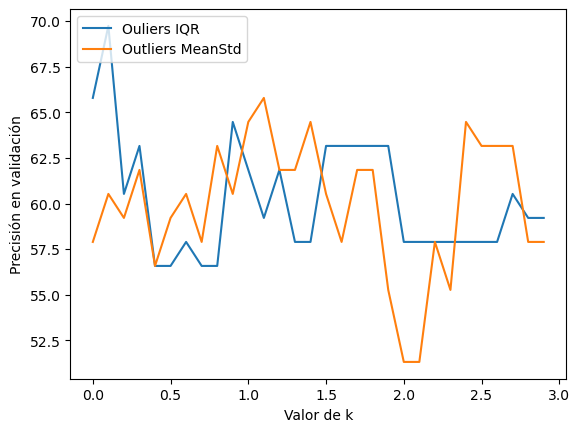

In [33]:
'''
Probamos los dos métodos de detección de outliers
'''

# Se crean listas con los siguientes contenidos
    # Los nombres de los métodos
    # Los constructores de las técnicas de muestreo con los híper-parámetros usados en la primera parte de la práctica
ks = np.arange(0,3,0.1)
valores_precicison_IQR = []
valores_precision_Mean = []
for k in ks:
    listaMetodos = ['Outliers MeanStd','Ouliers IQR']
    listaTecnicas = [OutlierDetecion_treatment_MeanStd(k),
                    OutlierDetecion_treatment_IQR(k)]

    nombres = listaMetodos
    resultados = pd.DataFrame(columns=nombres,index=["Acierto Train", "Acierto Validación"])

    for nombre, metodo in zip(listaMetodos, listaTecnicas):
        # Generamos la pipeline con los componentes adecuados
        pipe = Pipeline([(nombre,metodo),
                    ('DT',DecisionTreeClassifier(criterion='entropy',min_samples_leaf=0.01,min_samples_split=0.06,random_state=33))])
        
        pipe.fit(X_train,y_train)

        # Calculo los resultados sobre el conjunto de train
        y_pred = pipe.predict(X_train)
        resultado = np.round(accuracy_score(y_train,y_pred)*100,4)
        resultados[nombre]["Acierto Train"] = round(accuracy_score(y_train,y_pred)*100,5)
        #Idem para validación
        y_pred = pipe.predict(X_val)
        resultado = np.round(accuracy_score(y_val,y_pred)*100,4)
        # Se imprime el resultado obtenido en validación: mostrad el nombre de la técnica y su rendimiento
        resultados[nombre]["Acierto Validación"] = round(accuracy_score(y_val,y_pred)*100,5)
        #Almaceno el mejor resultado de precisión del método de la media
        if(nombre == 'Outliers MeanStd'):
            valores_precision_Mean.append(round(accuracy_score(y_val,y_pred)*100,5))

    #Almaceno el mejor resultado de precision del método del rango interquartil
    valores_precicison_IQR.append(round(accuracy_score(y_val,y_pred)*100,5))

plt.plot(ks,valores_precicison_IQR,label='Ouliers IQR')
plt.plot(ks,valores_precision_Mean,label='Outliers MeanStd')
plt.legend(loc=2)
plt.xlabel('Valor de k')
plt.ylabel('Precisión en validación')
print('Valor máximo de precisión en validación de {}'.format(np.max(valores_precicison_IQR)))

Una vez, obtenemos un descenso de la precisión de nuestro modelo de predicción. El motivo vuelve a ser el mismo caso que con la eliminación de ruido, teniendo más o menos pocos ejemplos, no conviene eliminar ninguno aunque se saga ligeramente de la media o esté por encima del rango interquartil. De hecho, se observa en la gráfica que el máximo resultado obtenido se da cuando la k vale apenas 0.01, con lo que no eliminamos casi ningún ejemplo. Llegamos a la siguiente conclusión: **no debemos eliminar instancias de nuestro conjunto de datos bajo ningún concepto, pues empeoran considerablemente la predicción, perdiendo información relevante y sobreentrenando**.

### 5.6: Estandarización <a class="anchor" id="5.6"></a>
Una vez hayamos podido eliminar o no ruido y outliers de nuestro conjunto de datos, podemos estandarizar la información que este contiene. Esto con el objetivo de que futuras métricas y métodos de predicción no den mayor o menor importancia a una variable únicamente por el rango de valores de la misma.

Vamos a probar los siguientes métodos: 
1. [*StandarScaler*](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler)
2. [*MinMaxScaler*](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler)
3. [*RobutScaler*](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html#sklearn.preprocessing.RobustScaler)

Al igual que con la detección de ruido, provaremos primero los métodos que hemos implementado anteriormente en la asignatura, para medir su rendimiento con nuestros datos. Ademñas, hemos añadirdo el `RobustScaler`, que se caracteriza por escalar los valores usando estadísticas que son robustas frente a los outliers, lo cual nos interesa al haber decidido no tratarlos al final.

In [34]:
'''
Probamos distintos métodos de estandarizar los datos
'''
from sklearn import preprocessing

# Se crean listas con los siguientes contenidos
    # Los nombres de los métodos
    # Los constructores de las técnicas de muestreo con los híper-parámetros usados en la primera parte de la práctica
listaMetodos = ['StandarScaler','MinMaxScaler','RobustScaler']
listaTecnicas = [preprocessing.StandardScaler(),
                 preprocessing.MinMaxScaler(),
                 preprocessing.RobustScaler()]

nombres = listaMetodos
resultados = pd.DataFrame(columns=nombres,index=["Acierto Train", "Acierto Validación"])

for nombre, metodo in zip(listaMetodos, listaTecnicas):
    X_train_estandarizado = X_train.copy()
    X_train_estandarizado = metodo.fit_transform(X_train_estandarizado)
    X_val_estandarizado = metodo.transform(X_val)

    # Generamos la pipeline con los componentes adecuados
    pipe = Pipeline([('DT',DecisionTreeClassifier(criterion='entropy',min_samples_leaf=0.01,min_samples_split=0.06,random_state=33))])

    pipe.fit(X_train_estandarizado,y_train)

    # Calculo los resultados sobre el conjunto de train
    y_pred = pipe.predict(X_train_estandarizado)
    resultado = np.round(accuracy_score(y_train,y_pred)*100,4)
    resultados[nombre]["Acierto Train"] = round(accuracy_score(y_train,y_pred)*100,5)
    #Idem para validación
    y_pred = pipe.predict(X_val_estandarizado)
    resultado = np.round(accuracy_score(y_val,y_pred)*100,4)
    # Se imprime el resultado obtenido en validación: mostrad el nombre de la técnica y su rendimiento
    resultados[nombre]["Acierto Validación"] = round(accuracy_score(y_val,y_pred)*100,5)
    
resultados

,StandarScaler,MinMaxScaler,RobustScaler
Acierto Train,89.88439,89.88439,89.88439
Acierto Validación,72.36842,72.36842,72.36842


Vemos que los tres estandarizadores obtienen el mismo resultado, y que además es el mismo que ya obteníamos con anterioridad. Siendo esto así, nos quedaremos con el `RobustScaler`, pues es el que nos puede aportar algo más de cara a la predicción futura en caso de que algo cambie.

In [35]:
'''
Predicción 'a pelo' sobre el conjunto de validación
'''
arbol = DecisionTreeClassifier(criterion='entropy',min_samples_leaf=0.01,min_samples_split=0.06,random_state=33)
arbol.fit(X_train,y_train)
y_pred = arbol.predict(X_val)
print(f'Precisión en validación: {np.round(accuracy_score(y_val,y_pred)*100,5)}')

Precisión en validación: 72.36842


### 5.7: Eliminación de variables correlacionadas y selección de variables <a class="anchor" id="5.7"></a>

Nuestro conjunto de datos se caracteriza por tener una cantidad de variables particularmente grande, especialmente teniendo en cuenta el número de ejemplos. Con este paso y el siguiente nuestro objetivo será reducir la dimensionalidad del problema eliminando aquellas variables que estén especialmente correlacionadas y más tarde seleccionando únicamente aquellas que aporten verdaderamente información a nuestro problema.

Al principio hemos mostrado la gráfica de correlación de las variables. En esta se apreciaba que la misma no era especialmente alta en la mayoría de los casos. En general, se diría que nuestro conjunto de datos cuenta con variables bastante diferenciadas entre sí. Así pues, nos vamos a centrar en buscar directamente la mejor selección de variables, ahorrando tiempo y matando dos pájaros de un tiro.

El primer paso consiste en obtener el rendimiento con todas las variables. Este lo podemos observar dos celdas más arriba. Es la precisión máxima que hemos alcanzado hasta ahora para el conjunto de validación, un **72.36%**.

In [36]:
# Se importa la librería de selección de variables
from sklearn import feature_selection, neighbors

En primer lugar, probamos técnicas de filtro uni-variable con `feature_selection`. Probaremos las tres métricas que existen para clasificación, es decir, las dos que ya utilizamos en su día en prácticas anteriores y `mutual_info_clasiff`, que utiliza información mutua y habitualmente obtiene mejores resultados. Nótese que solo usaremos el método `SelectKBest`. Esto debido a la redundancia de usar el método por porcentajes. 

[False False False False False False False False False False False False
 False False  True  True False False False  True  True False False  True
 False False  True  True  True  True  True False False False  True  True
  True False]


Text(0, 0.5, 'Precisión en validación')

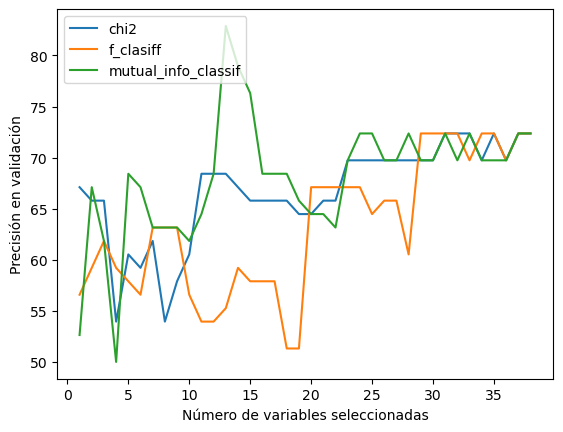

In [37]:
# Listas para almacenar los resultados de accuracy en train y test
listaAccTrain = []
listaAccTest = []

#Número de variables a seleccionar, desde 1 hasta 38, el máximo posible
num_mejor_variables = np.arange(1,39,1)

#Redefino la métrica para poder fijarle la semilla de forma externa
def mutual_info_classif_fixed_seed(X, y):
    # Fijo la semilla aleatoria antes de llamar al selector mutual_info_classif
    np.random.seed(1) #NO CAMBIAR ESTA SEMILLA
    return feature_selection.mutual_info_classif(X, y)

selectores = [feature_selection.chi2,feature_selection.f_classif,mutual_info_classif_fixed_seed]
resultados_val_CHI2 = []
resultados_val_f_clasiff = []
resultados_val_mutual = []

for selector in selectores:
    for numVar in num_mejor_variables:
        #Creamos una Pipeline
        pipe = Pipeline([('selector',feature_selection.SelectKBest(selector,k=numVar))
                        ,('clasificador',DecisionTreeClassifier(criterion='entropy',min_samples_leaf=0.01,min_samples_split=0.06,random_state=33))])
        #Entrenamiento
        pipe.fit(X_train,y_train)
        #Predicción de los datos de entrenamiento
        prediccionTrain = pipe.predict(X_train)
        #Llamada a la función que calcula el porcentaje de acierto para los datos de entrenamiento
        accTrain =  np.round(accuracy_score(y_train,prediccionTrain)*100,5)
        #Se añade el resultado a la lista de resultados de train
        listaAccTrain.append(accTrain)
        #Predicción de los datos de validacion
        prediccionVal = pipe.predict(X_val)
        #Llamada a la función que calcula el porcentaje de acierto para los datos de validacion
        accVal = np.round(accuracy_score(y_val,prediccionVal)*100,5)

        if(accVal == 82.89474):
            print(pipe.named_steps['selector'].get_support())
        #Se añade el resultado a la lista de resultados de validacion
        listaAccTest.append(accVal)
        #Almaceno los resultados conforme los obtengo para pintar la gráfica
        if(selector == feature_selection.chi2):
            resultados_val_CHI2.append(accVal)
        elif (selector == feature_selection.f_classif):
            resultados_val_f_clasiff.append(accVal)
        elif (selector == mutual_info_classif_fixed_seed):
            resultados_val_mutual.append(accVal)

plt.plot(num_mejor_variables,resultados_val_CHI2,label='chi2')
plt.plot(num_mejor_variables,resultados_val_f_clasiff,label='f_clasiff')
plt.plot(num_mejor_variables,resultados_val_mutual,label='mutual_info_classif')
plt.legend(loc=2)
plt.xlabel('Número de variables seleccionadas')
plt.ylabel('Precisión en validación')


Esta gráfica nos dice bastantes cosas, vayamos por partes.

En primer lugar, la métrica `mutual_info_classif` (que habíamos implementado de forma nueva nosotros), consigue mejorar el resultado de validación máximo obtenido hasta ahora. Veremos los valores concretos en un momento.

Por otra parte, hemos conseguido que la selección de variables tenga sentido, pues usando poco más de 10 de las 38 que teníamos inicialmente, podemos obtener ese resultado mejor que no habíamos logrado hasta ahora.

Veámos qué valores exactamente son los relevantes.

In [38]:
print('Seleccionando {} variables usando la métrica mutual_info_classif, obtenemos un rendimiento del {} en validación '.format(np.argmax(resultados_val_mutual)+1,np.max(resultados_val_mutual)))

Seleccionando 13 variables usando la métrica mutual_info_classif, obtenemos un rendimiento del 82.89474 en validación 


¿Y cuáles son estas 13 variables? Usando la función `get_support()` del selector, obtenemos una máscara booleana que podemos comparar con nuestras columnas para obtener los nombres de estas variables.

In [39]:
mascara =[False, False, False, False, False, False, False, False, False, False, False, False,False, False,  True,  True ,False, False, False,  True,  True ,False, False,  True,False, False,  True,  True,  True , True , True ,False, False ,False , True , True,True, False]
nombres = datos.columns[:-1]
nombres_variables_seleccionadas = nombres[mascara]
print(nombres_variables_seleccionadas)

Index(['press', 'unit_number', 'proff_cut', 'viscosity', 'humifity',
       'varnish_pct', 'press_speed', 'ink_pct', 'solvent_pct', 'ESA_voltage',
       'roller_durometer', 'current_density', 'anode_space_ratio'],
      dtype='object')


Además de los filtros uni-variables, podemos optar por el uso de los wrappers. En este caso, usando el método `RFECV`, que es más generalista y nos ayudará a ver si una selección de variables de este estilo es o no relevante para nuestro problema.

In [40]:
from sklearn import linear_model
# Creación de la Pipeline con los híper-parámetros adecuados
pipe =  Pipeline([('selector',feature_selection.RFECV(DecisionTreeClassifier(criterion='entropy',min_samples_leaf=0.01,min_samples_split=0.06,random_state=33),step=1,n_jobs= -1,cv=3))
                    ,('clasificador',DecisionTreeClassifier(criterion='entropy',min_samples_leaf=0.01,min_samples_split=0.06,random_state=33))])
# Entrenamiento
pipe.fit(X_train,y_train)

# Predicción de los datos de entrenamiento
prediccionTrain =  pipe.predict(X_train)
# Llamada a la función que calcula el porcentaje de acierto para los datos de entrenamiento
accTrain =  accuracy_score(y_train,prediccionTrain)*100
# Obtenemos el número de variables seleccionadas 
numeroVariablesSeleccionadas = pipe.named_steps.selector.n_features_
print('Manteniendo {} variables se obtiene un accuracy del {}% en entrenamiento'.format(numeroVariablesSeleccionadas, accTrain))

# Predicción de los datos de test
prediccionTest =  pipe.predict(X_val)
# Llamada a la función que calcula el porcentaje de acierto para los datos de test
accTest =  accuracy_score(y_val,prediccionTest)*100
print('Manteniendo {} variables se obtiene un accuracy del {}% en test'.format(numeroVariablesSeleccionadas, accTest))

Manteniendo 36 variables se obtiene un accuracy del 89.88439306358381% en entrenamiento
Manteniendo 36 variables se obtiene un accuracy del 72.36842105263158% en test


Si bien sí que hemos eliminado variables (2) manteniendo la misma precisión de validación que obteníamos antes, este método palidece en comparación con el anterior, con lo que no será el que usemos.

En conclusión, en cuanto a la eliminación y selección de variables, nos quedaremos con `mutual_info_classif`, que es el método que, de media, ofrece un mejor resultado en la relación número de variables - precisión en validación. Definimos el modelo final aquí debajo para sus futuros usos.

In [41]:
numero_variables = np.argmax(resultados_val_mutual)
selector_variables = feature_selection.SelectKBest(feature_selection.mutual_info_classif,k = numero_variables)

## 6: Solución y conclusiones <a class="anchor" id="1"></a>
Finalmente, vamos a evaluar nuestros prodecimientos entrenando diversos modelos para saver cómo de bueno es nuestro código a la hora de clasificar ejemplos reales. Probaremos tres modelos diferentes: `KNN`, `DecisionTreeClassifier` y `LogisticRegression`.

### 6.1: Modelos a evaluar <a class="anchor" id="6.1"></a>

Antes de nada, recordemos que la métrica que vamos a utilizar para medir el rendimiento de nuestro modelo es el `f-score`. Además, nos fijaremos especialmente en cuántos ejemplos de la clase positiva acertamos, pues es lo importante para nuestro problema, más que el accuracy general. Preciamente por esto, hemos implementado la posibilidad de calcular el mejor umbral, pudiendo variarlo y ajustar nuestros modelos a esta nueva vara de medir. A continuación se implementa todo el código pertinente.

In [42]:
'''
Funciones para el cálculo e implementación del umbral
'''
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.metrics import classification_report,precision_recall_curve,average_precision_score,make_scorer,f1_score

score_PR = make_scorer(score_func=average_precision_score,needs_threshold=True)

# Función que muestra el compromiso entre precision y recall para un clasificador (clf) y unos datos de entrada (X) y salida (y)
def muestra_balance_PR(clf, X, y):
    # Obtenemos las probabilidades de la clase positiva
    if hasattr(clf, 'predict_proba'):
        model_probs = clf.predict_proba(X)
    else:
        model_probs = clf.decision_function(X)
    
    model_probs = model_probs[:,1]
    
    # Obtenemos los umbrales que se generan y que caracterizan la curva PR (usar método precision_recall_curve)
    model_precision, model_recall, umbrales = precision_recall_curve(y-1,model_probs)
    # Añadimos 1 como umbral para que la gráfica vaya hasta dicho punto (el par PR ya está calculado)
    umbrales = np.insert(umbrales, umbrales.size, 1., axis=0)
    # Mostramos la figura: la precisión en rojo y el recall en azul
    plt.figure(figsize=(10,6))
    plt.plot(umbrales,model_recall,color='r',label='Recall')
    plt.plot(umbrales,model_precision,color='b',label='Precision')
    plt.xlabel('Umbrales')
    plt.legend(loc=0)


def clasificacion_umbral(probs_clase_positiva, umbral=0.5):
    return probs_clase_positiva>=umbral

def evaluar_mejor_umbral_fscore(model, umbral, X, y):
    # Evaluamos la calidad del mejor umbral con los ejemplos
    model_probs = model.predict_proba(X)[:,1]
    y_pred = clasificacion_umbral(model_probs,umbral)
    fscore = f1_score(y-1,y_pred)*100
    return fscore

def calcular_mejor_umbral_fscore(model, X_train, y_train, X_val, y_val):    
    # predecimos las probabilidades de predecir cada ejemplo de train y de validación en la clase positiva
    model_probs = model.predict_proba(X_train)[:,1]
    model_probs_val = model.predict_proba(X_val)[:,1]
    
    # calculamos todos los pares de puntos (recall, precision) y sus umbrales (método precision_recall_curve)
    model_precision, model_recall, umbrales = precision_recall_curve(y_train-1,model_probs)
    # Evaluamos el Fscore (método f1_score) de cada umbral 
    rendimiento_umbrales = []
    for umbral in umbrales:
        y_pred = clasificacion_umbral(model_probs_val,umbral)
        rendimiento_umbrales.append(f1_score(y_val-1,y_pred)*100)
    # Se consigue el índice del umbral que da mayor rendimiento
    indiceMejorUmbral = np.argmax(rendimiento_umbrales)
    # Se consigue el valor del mejor umbral
    mejorUmbral = umbrales[indiceMejorUmbral]
    print('Mejor umbral={:.3f}, Fscore en validacion={:.2f}'.format(mejorUmbral, rendimiento_umbrales[indiceMejorUmbral]))
    # Se devuelve el mejor umbral
    return mejorUmbral

Una vez hecho esto, vamos a recoger todos los pasos de preprocesamiento que hemos seleccionado y utilizado hasta ahora.

In [43]:
#Creamos los objetos para realizar las transformaciones
transBinario = ce.OrdinalEncoder(handle_missing='return_nan')
transMulticategorico = ce.TargetEncoder(handle_missing='return_nan',smoothing=0.000001,min_samples_leaf=10)

imputerIterativo = IterativeImputer(estimator=RandomForestRegressor(random_state=33),initial_strategy="median",random_state=33)

columnaBinaria = Pipeline([('transformacion',transBinario),
                            ('imputador', imputerIterativo)])
columnaMultivariante = Pipeline([('transformacion',transMulticategorico),
                            ('imputador', imputerIterativo)])
columnaNumerica = Pipeline([('imputador', imputerIterativo)])

preprocesamiento = ColumnTransformer([('binarias',columnaBinaria,variablesBinarias),
                                    ('multicategoricas',columnaMultivariante,variablesMulticategoricas),
                                    ('numericas',columnaNumerica,variablesNumericas)])

#Creamos el sampler
sampler = os.RandomOverSampler(random_state=33)

#Creamos el scaler
escaler = preprocessing.RobustScaler()

#Creamos la eliminacion de variables
numero_variables = np.argmax(resultados_val_mutual)
selector_variables = feature_selection.SelectKBest(feature_selection.mutual_info_classif, k=numero_variables)

Por último, entrenamos una serie de modelos para evaluar el rendimiento de todos nuestros procesos en general.

### Algoritmo KNN

Fitting 2 folds for each of 24 candidates, totalling 48 fits


Pipeline(steps=[('preprocesamiento',
                 ColumnTransformer(transformers=[('binarias',
                                                  Pipeline(steps=[('transformacion',
                                                                   OrdinalEncoder(handle_missing='return_nan')),
                                                                  ('imputador',
                                                                   IterativeImputer(estimator=RandomForestRegressor(random_state=33),
                                                                                    initial_strategy='median',
                                                                                    random_state=33))]),
                                                  ['grain_screened',
                                                   'proof_on_ctd_ink',
                                                   'blade_mfg', 'direct_steam',
                                                   't...
                                                   'ink_pct', 'solvent_pct',
                                                   'ESA_voltage',
                                                   'ESA_amperage', 'wax',
                                                   'hardener',
                                                   'roller_durometer',
                                                   'current_density',
                                                   'anode_space_ratio',
                                                   'chrome_content'])])),
                ('sampler', RandomOverSampler(random_state=33)),
                ('selector_variables',
                 SelectKBest(k=12,
                             score_func=<function mutual_info_classif at 0x00000262072C8C10>)),
                ('modelo',
                 KNeighborsClassifier(metric='manhattan', n_neighbors=7, p=3))])

Mejor umbral=0.429, Fscore en validacion=78.05
FSCORE OBTENIDO (VALIDACION): 78.04878048780488
FSCORE OBTENIDO (TEST): 67.0391061452514

Results on the test set:
              precision    recall  f1-score   support

           0       0.84      0.46      0.59        94
           1       0.54      0.88      0.67        68

    accuracy                           0.64       162
   macro avg       0.69      0.67      0.63       162
weighted avg       0.72      0.64      0.63       162

ACCURACY OBTENIDO: 63.580246913580254


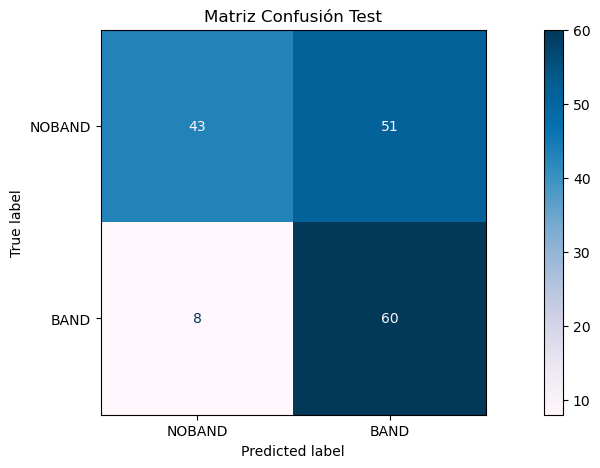

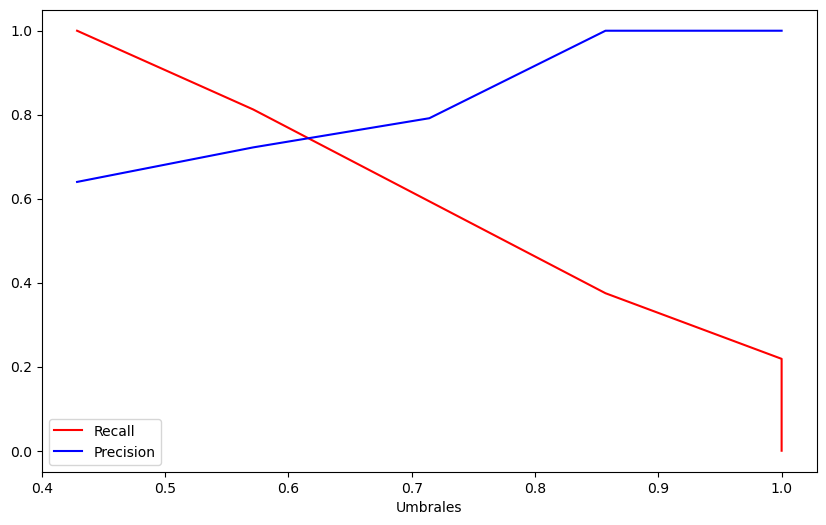

In [44]:
'''
KNeigborsClassifier
'''
#Se importa de la libreria scikit-learn de python (sklearn) el paquete correspondiente al k-means
from sklearn.neighbors import KNeighborsClassifier

#Creamos la pipeline
pipeline = Pipeline_in([('preprocesamiento',preprocesamiento),
                        ('sampler',sampler),
                        ('selector_variables',selector_variables),
                        ('modelo',KNeighborsClassifier())])

# Genera el diccionario param_grid con los valores indicados
parameter_space = {
    'modelo__n_neighbors': [3,5,7],
    'modelo__weights': ['uniform','distance'],
    'modelo__metric': ['manhattan','euclidean'],
    'modelo__p': [1, 3]
}

#Crea las variables de KMeans y Grid Search para el aprendizaje
clasificadorKNC = GridSearchCV(pipeline,parameter_space,cv=StratifiedKFold(n_splits=2),n_jobs=-1,scoring=score_PR,verbose=True)

# Entrena el modelo interno de GridSearchCV para obtener los mejores hiperparametros
clasificadorKNC = clasificadorKNC.fit(X=X_resto,y=y_resto)
display(clasificadorKNC.best_estimator_)

fig, ax = plt.subplots(1,figsize=(15,5))
ax.set_title("Matriz Confusión Test")
umbralKNC = calcular_mejor_umbral_fscore(clasificadorKNC,X_train_sin_transformar,y_train_sin_transformar,X_val_sin_transformar,y_val)
fscore = evaluar_mejor_umbral_fscore(clasificadorKNC,umbralKNC,X_val_sin_transformar,y_val)
print("FSCORE OBTENIDO (VALIDACION): {}".format(fscore))
fscore = evaluar_mejor_umbral_fscore(clasificadorKNC,umbralKNC,X_test,y_test)
print("FSCORE OBTENIDO (TEST): {}".format(fscore))

# Mostramos los datos mas interesantes de cada variable predicha
probs_clase_positiva = clasificadorKNC.predict_proba(X_test)[:,1]
y_true, y_pred = y_test-1, clasificacion_umbral(probs_clase_positiva, umbral=umbralKNC)
print('\nResults on the test set:')
print(classification_report(y_true, y_pred))
print("ACCURACY OBTENIDO: {}".format(accuracy_score(y_true, y_pred)*100))

#Obtenemos la matriz de confusión
cm = confusion_matrix(y_true, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["NOBAND","BAND"])
disp.plot(ax=ax,cmap='PuBu')
muestra_balance_PR(clasificadorKNC, X_val_sin_transformar, y_val)

Nuestro primer modelo nos has devuelto un f-score de 54.16. También obtenemos un recall del 57%. Recordemos que esta es la variable que más nos interesa para nuestro problema concreto.

En general, podemos definir estos resultados como mediocres desde el punto de vista del accuracy, pero esto era esperable dado que nuestro `grid_search` busca maximizar no esa métrica, sino el f-score. Vamos a entrenar más modelos para tener un marco de referencia sobre el que trabajar.

### Árbol de decisión

Fitting 2 folds for each of 18 candidates, totalling 36 fits


Pipeline(steps=[('preprocesamiento',
                 ColumnTransformer(transformers=[('binarias',
                                                  Pipeline(steps=[('transformacion',
                                                                   OrdinalEncoder(handle_missing='return_nan')),
                                                                  ('imputador',
                                                                   IterativeImputer(estimator=RandomForestRegressor(random_state=33),
                                                                                    initial_strategy='median',
                                                                                    random_state=33))]),
                                                  ['grain_screened',
                                                   'proof_on_ctd_ink',
                                                   'blade_mfg', 'direct_steam',
                                                   't...
                                                   'roller_durometer',
                                                   'current_density',
                                                   'anode_space_ratio',
                                                   'chrome_content'])])),
                ('sampler', RandomOverSampler(random_state=33)),
                ('selector_variables',
                 SelectKBest(k=12,
                             score_func=<function mutual_info_classif at 0x00000262072C8C10>)),
                ('modelo',
                 DecisionTreeClassifier(class_weight='balanced',
                                        min_samples_leaf=0.5,
                                        min_samples_split=0.06, random_state=33,
                                        splitter='random'))])

Mejor umbral=0.500, Fscore en validacion=59.26
FSCORE OBTENIDO (VALIDACION): 59.25925925925925
FSCORE OBTENIDO (TEST): 59.13043478260869

Results on the test set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        94
           1       0.42      1.00      0.59        68

    accuracy                           0.42       162
   macro avg       0.21      0.50      0.30       162
weighted avg       0.18      0.42      0.25       162

ACCURACY OBTENIDO: 41.9753086419753


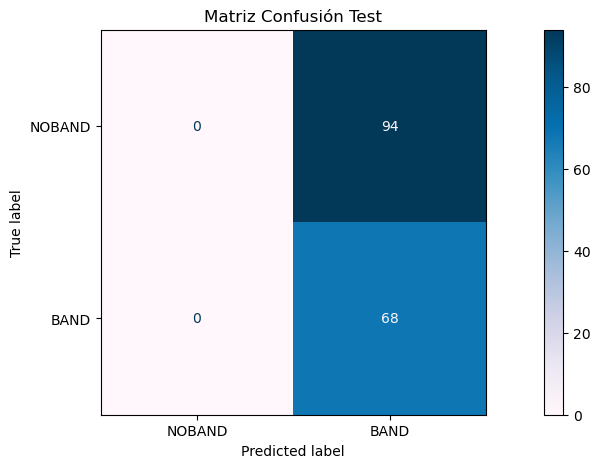

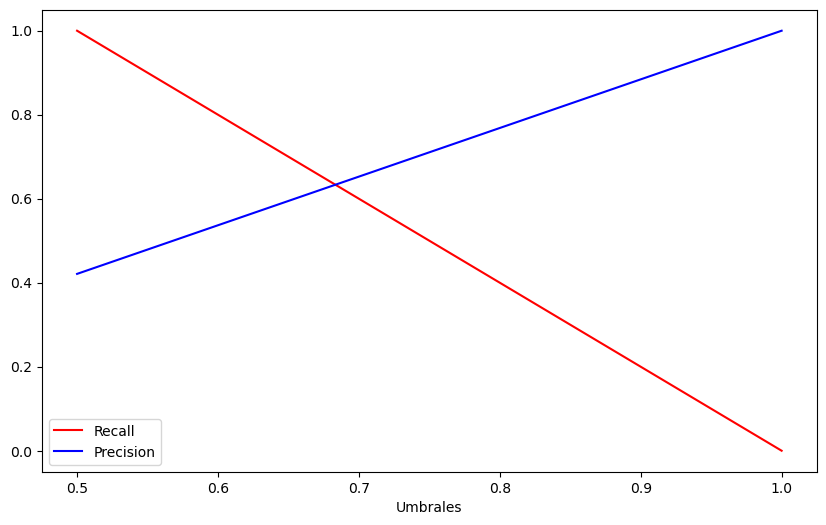

In [45]:
'''
DecisionTreeClassifier
'''
#Se importa de la libreria scikit-learn de python (sklearn) el paquete correspondiente al k-means
from sklearn.tree import DecisionTreeClassifier

#Creamos la pipeline
pipeline = Pipeline_in([('preprocesamiento',preprocesamiento),
                        ('sampler',sampler),
                        ('selector_variables',selector_variables),
                        ('modelo',DecisionTreeClassifier(criterion='gini',class_weight='balanced',random_state=33))])

# Genera el diccionario param_grid con los valores indicados
parameter_space = {
    'modelo__splitter': ['best','random'],
    'modelo__min_samples_leaf': [0.01,0.5,2],
    'modelo__min_samples_split': [0.06,1,2]
}

#Crea las variables de KMeans y Grid Search para el aprendizaje
clasificadorDTC = GridSearchCV(pipeline,parameter_space,cv=StratifiedKFold(n_splits=2),n_jobs=-1,scoring=score_PR,verbose=True)

# Entrena el modelo interno de GridSearchCV para obtener los mejores hiperparametros
clasificadorDTC = clasificadorDTC.fit(X=X_resto,y=y_resto)
display(clasificadorDTC.best_estimator_)

fig, ax = plt.subplots(1,figsize=(15,5))
ax.set_title("Matriz Confusión Test")
umbralDTC = calcular_mejor_umbral_fscore(clasificadorDTC,X_train_sin_transformar,y_train_sin_transformar,X_val_sin_transformar,y_val)
fscore = evaluar_mejor_umbral_fscore(clasificadorDTC,umbralDTC,X_val_sin_transformar,y_val)
print("FSCORE OBTENIDO (VALIDACION): {}".format(fscore))
fscore = evaluar_mejor_umbral_fscore(clasificadorDTC,umbralDTC,X_test,y_test)
print("FSCORE OBTENIDO (TEST): {}".format(fscore))

# Mostramos los datos mas interesantes de cada variable predicha
probs_clase_positiva = clasificadorDTC.predict_proba(X_test)[:,1]
y_true, y_pred = y_test-1, clasificacion_umbral(probs_clase_positiva, umbral=umbralDTC)
print('\nResults on the test set:')
print(classification_report(y_true, y_pred))
print("ACCURACY OBTENIDO: {}".format(accuracy_score(y_true, y_pred)*100))

#Obtenemos la matriz de confusión
cm = confusion_matrix(y_true, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["NOBAND","BAND"])
disp.plot(ax=ax,cmap='PuBu')
muestra_balance_PR(clasificadorDTC, X_val_sin_transformar, y_val)

Los resultados obtenidos por el árbol de decisión empeoran notablemente respecto a los que nos devolvía KNN. Aquí, el recall de la clase positiva es de apenas un 40%. Podemos achacar este empeoramiento al funcionamiento de los árboles, que tienden a sobreentrenar y no obtener resultados que generalicen especialmente bien. De momento, descartamos este modelo.

### Regresión logística

Fitting 2 folds for each of 18 candidates, totalling 36 fits


Pipeline(steps=[('preprocesamiento',
                 ColumnTransformer(transformers=[('binarias',
                                                  Pipeline(steps=[('transformacion',
                                                                   OrdinalEncoder(handle_missing='return_nan')),
                                                                  ('imputador',
                                                                   IterativeImputer(estimator=RandomForestRegressor(random_state=33),
                                                                                    initial_strategy='median',
                                                                                    random_state=33))]),
                                                  ['grain_screened',
                                                   'proof_on_ctd_ink',
                                                   'blade_mfg', 'direct_steam',
                                                   't...
                                                   'ESA_amperage', 'wax',
                                                   'hardener',
                                                   'roller_durometer',
                                                   'current_density',
                                                   'anode_space_ratio',
                                                   'chrome_content'])])),
                ('sampler', RandomOverSampler(random_state=33)),
                ('selector_variables',
                 SelectKBest(k=12,
                             score_func=<function mutual_info_classif at 0x00000262072C8C10>)),
                ('modelo',
                 LogisticRegression(C=1e-101, max_iter=10000, multi_class='ovr',
                                    random_state=33))])

Mejor umbral=0.500, Fscore en validacion=59.26
FSCORE OBTENIDO (VALIDACION): 59.25925925925925
FSCORE OBTENIDO (TEST): 59.13043478260869

Results on the test set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        94
           1       0.42      1.00      0.59        68

    accuracy                           0.42       162
   macro avg       0.21      0.50      0.30       162
weighted avg       0.18      0.42      0.25       162

ACCURACY OBTENIDO: 41.9753086419753


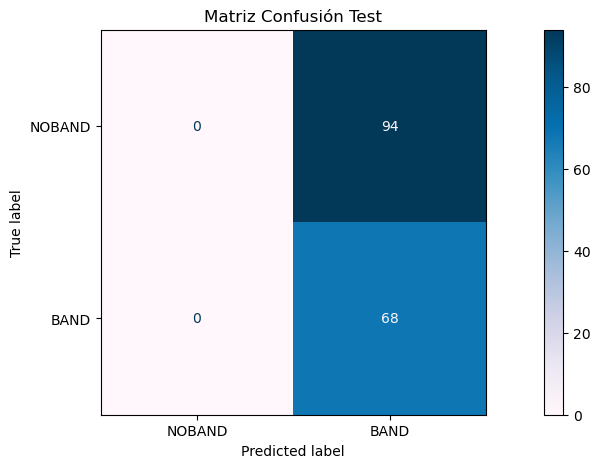

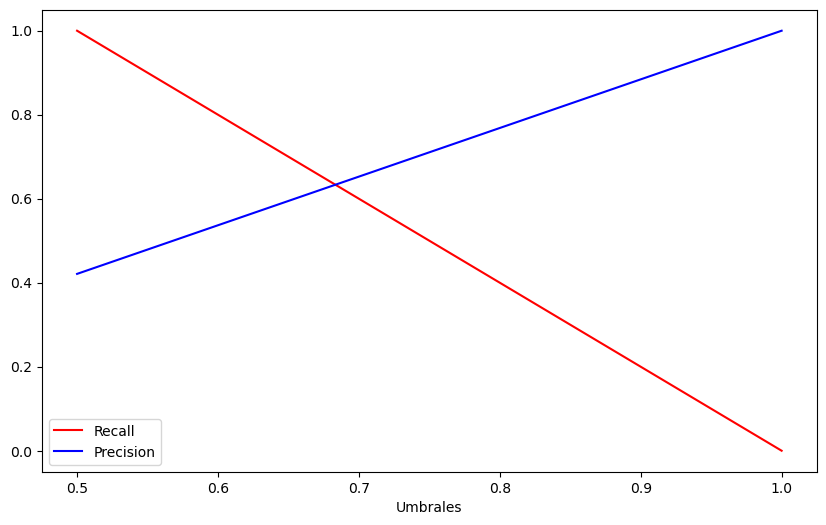

In [46]:
'''
LogisticRegression
'''
#Se importa de la libreria scikit-learn de python (sklearn) el paquete correspondiente al k-means
from sklearn.linear_model import LogisticRegression

#Creamos la pipeline
pipeline = Pipeline_in([('preprocesamiento',preprocesamiento),
                        ('sampler',sampler),
                        ('selector_variables',selector_variables),
                        ('modelo',LogisticRegression(max_iter=10000, random_state=33, multi_class='ovr'))])

# Genera el diccionario param_grid con los valores indicados
parameter_space = {
    'modelo__penalty': ['l2', None],
    'modelo__C': [1e+101, 1, 1e-101],
    'modelo__solver': ['newton-cg', 'lbfgs', 'saga'],
}
#Crea las variables de KMeans y Grid Search para el aprendizaje
clasificadorLR = GridSearchCV(pipeline,parameter_space,cv=StratifiedKFold(n_splits=2),n_jobs=-1,scoring=score_PR,verbose=True)

# Entrena el modelo interno de GridSearchCV para obtener los mejores hiperparametros
clasificadorLR = clasificadorLR.fit(X=X_resto,y=y_resto)
display(clasificadorLR.best_estimator_)

fig, ax = plt.subplots(1,figsize=(15,5))
ax.set_title("Matriz Confusión Test")
umbralLR = calcular_mejor_umbral_fscore(clasificadorLR,X_train_sin_transformar,y_train_sin_transformar,X_val_sin_transformar,y_val)
fscore = evaluar_mejor_umbral_fscore(clasificadorLR,umbralLR,X_val_sin_transformar,y_val)
print("FSCORE OBTENIDO (VALIDACION): {}".format(fscore))
fscore = evaluar_mejor_umbral_fscore(clasificadorLR,umbralLR,X_test,y_test)
print("FSCORE OBTENIDO (TEST): {}".format(fscore))

# Mostramos los datos mas interesantes de cada variable predicha
probs_clase_positiva = clasificadorLR.predict_proba(X_test)[:,1]
y_true, y_pred = y_test-1, clasificacion_umbral(probs_clase_positiva, umbral=umbralLR)
print('\nResults on the test set:')
print(classification_report(y_true, y_pred))
print("ACCURACY OBTENIDO: {}".format(accuracy_score(y_true, y_pred)*100))

#Obtenemos la matriz de confusión
cm = confusion_matrix(y_true, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["NOBAND","BAND"])
disp.plot(ax=ax,cmap='PuBu')
muestra_balance_PR(clasificadorLR, X_val_sin_transformar, y_val)

La regresión logística nos devuelve un resultado interesante. En esta ocasión, el recall de la clase positiva es de un 84%, una mejora sustancial con respecto a lo obtenido hasta el momento. Esto podría invitar a escoger este modelo, pero lo cierto es que esta mejora por una parte viene acompañada de un desplome considerable en la otra clase. Si bien la clase negativa no nos interesa tanto, no es razonable escoger un modelo que solo hace bien la mitad del trabajo, con lo que finalmente escogeremos como modelo final aquel que tenga mejor f-score, para nivelar el rendimiento del modelo sobre las dos clases.

In [47]:
'''
Eleccion del mejor clasificador
'''
fscore_modelos = []

for clasificador,umbral in zip([clasificadorKNC.best_estimator_,clasificadorDTC.best_estimator_,clasificadorLR.best_estimator_],[umbralKNC,umbralDTC,umbralLR]):
    fscore_modelos.append(evaluar_mejor_umbral_fscore(clasificador,umbral,X_val_sin_transformar,y_val))

best_modelo = [clasificadorKNC.best_estimator_,clasificadorDTC.best_estimator_,clasificadorLR.best_estimator_][np.argmax(fscore_modelos)]
best_umbral = [umbralKNC,umbralDTC,umbralLR][np.argmax(fscore_modelos)]
display(best_modelo)
print(np.max(fscore_modelos),best_umbral)

# FSCORE OBTENIDO (TEST): 54.166666666666664
# ACCURACY OBTENIDO: 59.25925925925925

Pipeline(steps=[('preprocesamiento',
                 ColumnTransformer(transformers=[('binarias',
                                                  Pipeline(steps=[('transformacion',
                                                                   OrdinalEncoder(handle_missing='return_nan')),
                                                                  ('imputador',
                                                                   IterativeImputer(estimator=RandomForestRegressor(random_state=33),
                                                                                    initial_strategy='median',
                                                                                    random_state=33))]),
                                                  ['grain_screened',
                                                   'proof_on_ctd_ink',
                                                   'blade_mfg', 'direct_steam',
                                                   't...
                                                   'ink_pct', 'solvent_pct',
                                                   'ESA_voltage',
                                                   'ESA_amperage', 'wax',
                                                   'hardener',
                                                   'roller_durometer',
                                                   'current_density',
                                                   'anode_space_ratio',
                                                   'chrome_content'])])),
                ('sampler', RandomOverSampler(random_state=33)),
                ('selector_variables',
                 SelectKBest(k=12,
                             score_func=<function mutual_info_classif at 0x00000262072C8C10>)),
                ('modelo',
                 KNeighborsClassifier(metric='manhattan', n_neighbors=7, p=3))])

78.04878048780488 0.42857142857142855


In [48]:
#best_modelo.fit(X_resto,y_resto)
print(accuracy_score(y_test,best_modelo.predict(X_test)))
print(f1_score(y_test,best_modelo.predict(X_test)))

0.6790123456790124
0.7263157894736842


### 6.2: Conclusiones e interpretabilidad <a class="anchor" id="6.2"></a>

A lo largo de esta práctica hemos obtenido multitud de resultados interesantes. Desde los efectos de aplicar Over o Undersampling, el resultado nocivo de la eliminación de ruido o el efectivísimo método de selección de variables. Con esto podemos sacar diversas conclusiones que ya hemos ido exponiendo, como porqué aplicar eliminación de outliers es mala idea, o cómo afecta la imputación en el resto del proceso.

Sin embargo, esta información relativa a nuestro conjunto de datos, no nos revela auténtica información intrínseca a nuestro problema, es decir, que pudiera ser relevante para un hipotético "experto" que nos hubiera solicitado este estudio. Para afrontar esta carencia, vamos a implementar modelos que nos permitan **interpretar nuestro modelo** y ver cuál es la relevancia de las variables, el impacto de estas y la relación entre ellas.

#### Valores SHAP
Los valores SHAP (Shapley Additive Explanations) miden la contribución marginal de cada una de las variables de nuestro conjunto de datos. Es decir, cómo de importante es una variable a la hora de clasificar un ejemplo como clase positiva o clase negativa. Obteniendo estos valores seremos capaces de conocer qué variables son más importantes, y en qué medida.

Veamos en primer lugar cuáles son las probabilidades a priori de nuestros ejemplos. Cómo hemos balanceado nuestro ejemplos usando el random over sampler, sabemos que la probabilidad a priori de ambas clases es de 0.5. Así pues, lo que observaremos ahora es cómo de seguros, desde ese 0.5 inicial, estamos de clasificar un ejemplo como otra de las clases. 

Nota: por como hemos transformado la variable de salida, la clase positiva (BAND) es el número 2, y la clase negativa (NOBAND) es la número 1.

In [49]:
# Elegimos un ejemplo a clasificar
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(n_estimators=10, random_state=0).fit(X_train, y_train)
indice_ejemplo_a_predecir = 4
ejemplo_a_predecir = (X_val[indice_ejemplo_a_predecir].reshape(1, -1))
clase_ejemplo_a_predecir = y_val.to_numpy()[indice_ejemplo_a_predecir]
# Lo clasificamos y mostramos su clase y las probabilidades
probabilidades = RF.predict_proba(ejemplo_a_predecir)
clase = RF.predict(ejemplo_a_predecir)
print('La clase predicha es {} y las probabilidades son {}'.format(clase[0],probabilidades.ravel()))
print('El ejemplo es de la clase {}'.format(clase_ejemplo_a_predecir))

La clase predicha es 2 y las probabilidades son [0.1 0.9]
El ejemplo es de la clase [2]


Observamos que la probabilidad de ser de la clase positiva de este ejemplo es de 0.9. Vamos a estudiar qué efectos tienen las variables para llegar desde el 0.5 inicial hasta este 0.9

In [50]:
import shap
import pandas as pd

# Elegir un ejemplo a clasificar y convertirlo a formato Series
indice_ejemplo_a_predecir = 4
ejemplo_a_predecir = pd.Series(X_val[indice_ejemplo_a_predecir])

# Crear un objeto de la clase TreeExplainer para un modelo basado en árboles de decisión
explainer = shap.TreeExplainer(RF)

# Calcular los valores SHAP
shap_values = explainer.shap_values(ejemplo_a_predecir)

# Obtener los nombres de las variables
nombres_variables = datos.columns[:-1]  # Reemplaza con los nombres reales

# Mostrar la descomposición con los nombres de las variables
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], ejemplo_a_predecir, feature_names=nombres_variables)

Observamos que la variable "ink_temperature" es la más determinante a la hora de decidir. No obstante, recordemos que antes hemos aplicado un proceso de selección de variables. ¿Coinciden las ahí seleccionadas con las obtenidas por los valores SHAP?

Veamos primero cuáles eran esas variables seleccionadas.

In [51]:
nombres_variables_seleccionadas

Index(['press', 'unit_number', 'proff_cut', 'viscosity', 'humifity',
       'varnish_pct', 'press_speed', 'ink_pct', 'solvent_pct', 'ESA_voltage',
       'roller_durometer', 'current_density', 'anode_space_ratio'],
      dtype='object')

La variable que los valores SHAP consideran más importante para este ejemplo, "ink_temperature" no aparece en las seleccionadas, aunque otras variables sí. ¿De dónde viene esta diferencia? El problema es que aquí solo trabajamos con un ejemplo, con lo que no podemos extraer conclusiones generales a partir de él. Necesiatamos otros métodos de interpretabilidad que empleen informacioón goblal. Veámos cómo.

#### Permutacion Importance
Vamos a determinar la importancia de nuestras variables esta vez usando la información de todos los ejemplos, con lo que deberíamos obtener más y mejor información. Usamos el método `summary_plot` para mostrar los resultados.

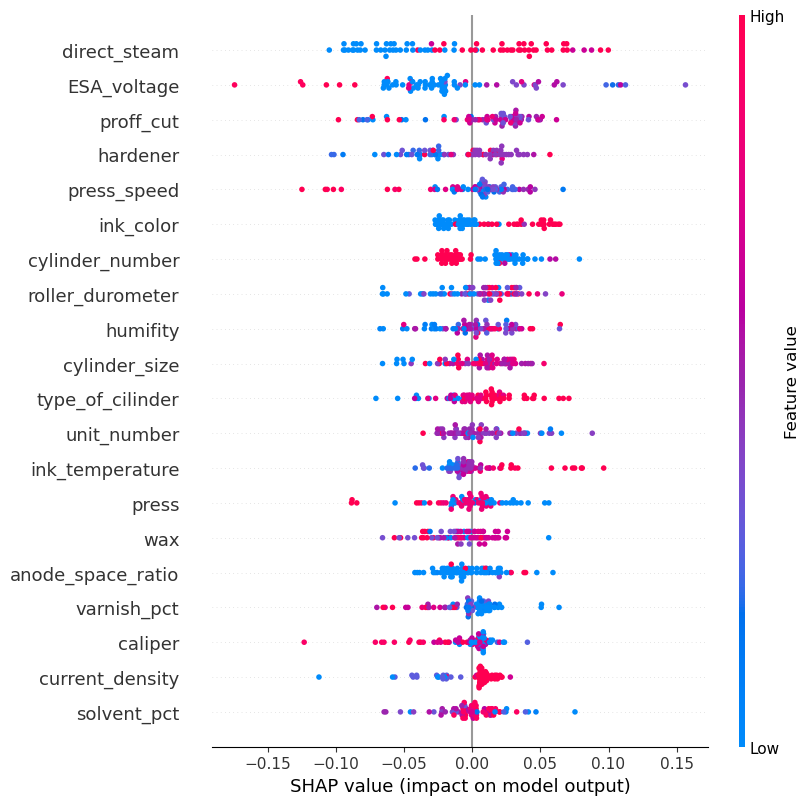

In [52]:
# Calculamos los valores SHAP para obtener la importancia global de cada variable en el modelo
shap_values = shap.TreeExplainer(RF).shap_values(X_val)
# Calculamos los valores SHAP para obtener la importancia global de cada variable en el modelo
explainer = shap.TreeExplainer(RF).shap_values(X_val)
nombres_variables = datos.columns[:-1]
# Mostramos el resultados sin agrupar: sin hacer un gráfico de barras
    # En caso de problemas de regresión se mostraría shap_values
shap.summary_plot(shap_values[1], X_val,feature_names=nombres_variables)

Recordemos cómo interpretar esta gráfica.
Las variables se ordenan por importancia de forma descendente, con lo que, en este caso, direc_steam. Interesante, pues ni los valores shap uni-variables ni la selección de variables tienen esta en cuenta en lo absoluto (en el caso de SHAP values, no la llegamos a ver impresa).

¿A qué podemos achacar esto? En primer lugar, recalcar que muchas de las otras variables que este método considera importantes sí se encuentran presentes en nuestra selección de variables. Sin embargo, llama la atención que la primera nada menos no esté presente en uno de los conjuntos. Teorizamos que esto puede deberse al funcionamiento de nuestro selector de variables, basado en los vecinos más cercanos. Esta selección funciona, por tanto, en base a la disposición espacial de los puntos, mientras que los valores shap trabajan de forma independiente a esto. Esta diferencia podría saer la causa de esta diferencia.

En cualquier caso, insistimos en el, aún así, parecido entre esta selección y la anterior, con lo que concluimos que la importancia de estas variables sí se debe tener en cuenta, y sí que influyen en la decisión final de nuestro clasficador.

## 7: Líneas futuras <a class="anchor" id="7"></a>
A lo largo del proyecto nos hemos dejado varias ideas sobre el tintero. Además, muchos de los métodos que hemos aplicado no han proporcionado mejores resultados, con lo que no hemos podido estudiar su impacto real sobre nuestros datos en la predicción final.

En definitiva, como líneas futuras, nos gustaría mejorar nuestros métodos para probar más combinaciones de todos los preprocesamientos que hemos probado. En concreto, nos gustaría estudiar el efecto de los outliers y del ruido sobre los datos, así como probar otras métricas de rendimiento.